Master in AI&DS - Progetto per il modulo Deep Learning

"Modelli per la classificazione di immagini di *CIFAR-100*"


a cura di Francesca Aceto, Rosa Maria Bruno, Francesca Ricci



---



## Introduzione

In questo progetto viene sviluppato un modello di Deep Learning utilizzando la libreria *Keras*, con backend *TensorFlow*. L'obiettivo principale è la classificazione automatica di immagini appartenenti al dataset **CIFAR-100**, un benchmark ampiamente riconosciuto nell’ambito della visione artificiale.

Il dataset **CIFAR-100** contiene **60.000 immagini a colori** di dimensione 32x32 pixel, suddivise in **100 classi** distinte, ciascuna contenente 600 immagini. Il set di dati è organizzato in **50.000 immagini di addestramento** (*training set*) e **10.000 immagini di test** (*test set*). Le classi rappresentano un’ampia gamma di categorie visive, tra cui animali, veicoli, oggetti naturali e artificiali.

Rispetto al più semplice CIFAR-10, questo dataset presenta una maggiore complessità dovuta all’elevato numero di classi, alla limitata dimensione delle immagini e alla possibile somiglianza visiva tra alcune categorie. Tali caratteristiche rendono il CIFAR-100 una scelta particolarmente adatta per valutare le capacità di generalizzazione e discriminazione dei modelli di rete neurale profonda.

**Fonte:** [https://www.cs.toronto.edu/~kriz/cifar.html](https://www.cs.toronto.edu/~kriz/cifar.html)


## Caricamento dati e pre-processing

In [ ]:
# ==================================================
# Importing libraries
# ==================================================
# Librerie di base
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# TensorFlow / Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential, Model, save_model, load_model
from tensorflow.keras.layers import (Conv2D, MaxPool2D, Dense, Dropout, BatchNormalization, Flatten, Input)
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.callbacks import EarlyStopping

# Dataset esterni
import tensorflow_datasets as tfds

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# funzione di utilità per il caricamento dei modelli salvati con joblib.load
from google.colab import drive
drive.mount('/content/drive')
model_path = '/content/drive/MyDrive/'

def load_model(model_name):
  path = model_path + model_name
  if 'model' in globals():
    print("Modello già caricato.")
    return model
  elif os.path.exists(path):
    model = joblib.load(path)
    print("Modello caricato con successo da:", path)
    return model
  else:
    print("Modello non trovato in: ", path)
    return None

Mounted at /content/drive


Fissiamo i seed affinchè i risultati degli addestramenti siano quanto più simili possibili da run a run.

In [ ]:
# ==================================================
# Seed setting
# ==================================================
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

Carichiamo ora il dataset **CIFAR-100**, disponibile direttamente tramite Keras. Utilizzeremo la modalità `fine` per lavorare con tutte le 100 classi distinte.

In [ ]:
# ==================================================
# Data loading
# ==================================================
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Stampiamo ora le dimensioni dei dati di training e di test.

In [ ]:
print("Dimensione dati di training: ", x_train.shape)
print("Dimensione dati di test: ", x_test.shape)

Dimensione dati di training:  (50000, 32, 32, 3)
Dimensione dati di test:  (10000, 32, 32, 3)


Il dataset è composto da 50.000 immagini per il training e 10.000 per il test. Ciascuna immagine ha una risoluzione di 32×32 pixel ed è a colori, con 3 canali (rosso, verde e blu).

In [ ]:
classi_univoche = np.unique(y_train)
num_classi = len(classi_univoche)

print(f"Numero totale di classi: {num_classi}")
print(f"Classi nel training set: {classi_univoche}")

Numero totale di classi: 100
Classi nel training set: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


Si procede con la normalizzazione delle immagini: i valori dei pixel vengono scalati da [0, 255] a [0, 1].
Questo passaggio migliora la stabilità numerica e accelera la convergenza durante l'addestramento.

In [ ]:
# ==================================================
# Data Normalizaion
# ==================================================
x_train_norm, x_test_norm = x_train / 255.0, x_test / 255.0


In [ ]:
print(f"Nuovo range valori pixel (x_train): [{x_train_norm.min()}, {x_train_norm.max()}]")
print(f"Nuovo range valori pixel (x_test): [{x_test_norm.min()}, {x_test_norm.max()}]")

Nuovo range valori pixel (x_train): [0.0, 1.0]
Nuovo range valori pixel (x_test): [0.0, 1.0]


Visualizziamo un campione di immagini per comprenderne la varietà. Per ogni immagine viene mostrata l'etichetta corrispondente (classe) in formato testuale.
Questo aiuta a familiarizzare con il contenuto del dataset e verificare che il caricamento sia avvenuto correttamente.

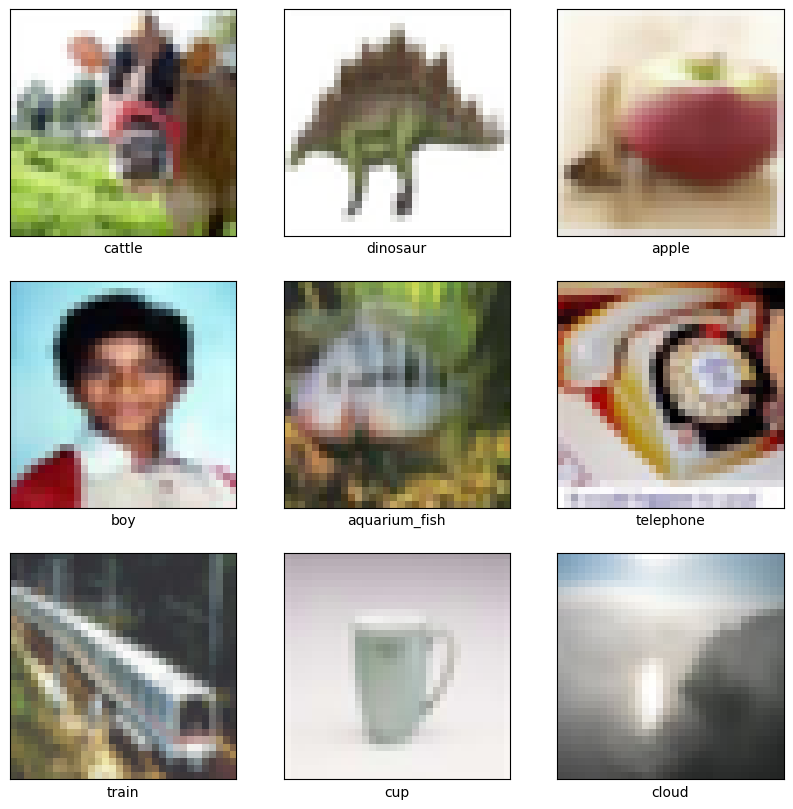

In [ ]:
# ==================================================
# Data Visualization
# ==================================================

# Etichette
class_names = [
    'apple','aquarium_fish','baby','bear','beaver','bed','bee','beetle','bicycle','bottle','bowl','boy','bridge','bus','butterfly','camel','can','castle','caterpillar','cattle','chair','chimpanzee','clock','cloud','cockroach','couch','cra','crocodile','cup','dinosaur','dolphin','elephant','flatfish','forest','fox','girl','hamster','house','kangaroo','computer_keyboard','lamp','lawn_mower','leopard','lion','lizard','lobster','man','maple_tree','motorcycle','mountain','mouse','mushroom','oak_tree','orange','orchid','otter','palm_tree','pear','pickup_truck','pine_tree','plain','plate','poppy_flower','porcupine','possum','rabbit','raccoon','ray','road','rocket','rose','sea','seal','shark','shrew','skunk','skyscraper','snail','snake','spider','squirrel','streetcar','sunflower','sweet_pepper','table','tank','telephone','television','tiger','tractor','train','trout','tulip','turtle','wardrobe','whale','willow_tree','wolf','woman','worm'
]

# Visualizzazione
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    plt.xlabel(class_names[y_train[i][0]])
plt.show()

# Definizione dei modelli

## Modello 1: CNN base

Come primo modello scegliamo una rete neurale convoluzionale (CNN) con la seguente architettura:
- 3 blocchi Conv2D + MaxPooling2D per estrarre progressivamente caratteristiche spaziali
- Un livello Flatten per passare dalla parte convoluzionale a quella completamente connessa
- Un layer Dense con 256 neuroni e attivazione ReLU
- Un layer Dropout con tasso 0.5 per ridurre overfitting
- Un layer di output con 100 neuroni (uno per ciascuna classe) e attivazione softmax


In [ ]:
# ==================================================
# Model Definition - MODEL 1: CNN BASE
# ==================================================
def create_base_cnn():
  model = models.Sequential([
      layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(32,32,3)),
      layers.MaxPooling2D((2,2)),

      layers.Conv2D(64, (3,3), activation='relu', padding='same'),
      layers.MaxPooling2D((2,2)),

      layers.Conv2D(128, (3,3), activation='relu', padding='same'),
      layers.MaxPooling2D((2,2)),

      layers.Flatten(),
      layers.Dense(256, activation='relu'),
      layers.Dropout(0.5),
      layers.Dense(100, activation='softmax')  # 100 classi
  ])
  return model

Come ottimizzatore viene usato Adam, per la sua efficienza e adattività nel training di reti neurali.
La funzione di perdita "sparse_categorical_crossentropy" è adatta a problemi di classificazione multi-classe quando le etichette sono codificate come interi (e non come one-hot).
Come metrica viene valutata la accuracy per monitorare la percentuale di classificazioni corrette durante l’addestramento e la valutazione.


In [ ]:
# ==================================================
# Model Compilation
# ==================================================

print("\n" + "="*50)
print("MODELLO 1: CNN BASE")
print("="*50)

model1 = load_model("model1.pkl")

if model1 is None:
  print("model1 None")
  model1 = create_base_cnn();
  model1.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  # salvataggio modello base
  joblib.dump(model1, model_path + 'model1.pkl')

print("Architettura del Modello 1:")
model1.summary()


MODELLO 1: CNN BASE
Modello non trovato in:  /content/drive/MyDrive/model1.pkl
model1 None
Architettura del Modello 1:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_67 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_69 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 100)            │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 643,492 (2.45 MB)

 Trainable params: 643,492 (2.45 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# ==================================================
# Model Training
# ==================================================

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history1 = load_model("history1.pkl")

if history1 is None:
  print("\nInizio training Modello 1...")
  history1 = model1.fit(x_train_norm, y_train,
                      batch_size=64,
                      epochs=20,
                      validation_split=0.1,
                      callbacks=[early_stop])
  # salvataggio history e modello addestrato
  joblib.dump(history1, model_path + 'history1.pkl')
  joblib.dump(model1, model_path + 'model1.pkl') #sovrascrive modello base

Modello non trovato in:  /content/drive/MyDrive/history1.pkl

Inizio training Modello 1...
Epoch 1/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.0396 - loss: 4.3414 - val_accuracy: 0.1618 - val_loss: 3.5693
Epoch 2/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.1490 - loss: 3.5976 - val_accuracy: 0.2406 - val_loss: 3.1553
Epoch 3/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.2148 - loss: 3.2325 - val_accuracy: 0.2906 - val_loss: 2.8994
Epoch 4/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.2558 - loss: 2.9997 - val_accuracy: 0.3152 - val_loss: 2.7547
Epoch 5/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.2901 - loss: 2.8279 - val_accuracy: 0.3466 - val_loss: 2.6145
Epoch 6/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.3150 - loss: 2.6924 - val_accuracy: 0.3512 - val_loss: 2.5623
Epoch 7/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.3406 - loss: 2.5754 - val_accuracy: 0.3650 - val_loss: 2.4698
Epoch 8/20
70

L'addestramento mostra un miglioramento costante della loss e dell'accuracy sia sul training set che sul validation set già durante le prime 9 epoche.
Inoltre, in particolare:
- l'accuracy di training passa dal 4% a circa 45% in 12 epoche;
- l'accuracy di validazione migliora da ~16% fino a un massimo di circa 39% dall’epoca 9-10, per poi diminuire leggermente e crescere nuovamente;
- la val_loss si riduce costantemente, dopodiché smette di migliorare e comincia a peggiorare leggermente.

Questo comportamento indica che il modello sta imparando correttamente durante le prime epoche, ma oltre un certo punto tende a overfittare i dati di addestramento. Il meccanismo di EarlyStopping è efficace: interrompe l’addestramento dopo che per 3 epoche consecutive la val_loss non migliora più in modo significativo, evitando training inutile e possibile overfitting.

Definiamo alcune funzioni di utilità per rappresentare l'andamento di accuracy e loss nel tempo:

In [ ]:
# ==================================================
# Accuracy plot function
# ==================================================

def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy nel tempo')
    plt.grid(True)
    plt.show()

# ==================================================
# Loss plot function
# ==================================================

def plot_loss(history):
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss nel tempo')
    plt.grid(True)
    plt.show()


Per il modello 1 con rete CNN base:

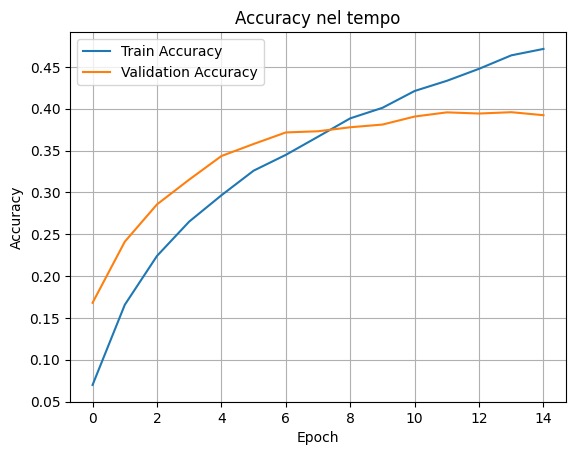

In [ ]:
# Accuracy plot
plot_accuracy(history1)

L'accuracy sui dati di training aumenta costantemente con l'aumentare delle epoche. Il modello sta imparando e si sta adattando sempre meglio ai dati su cui è stato addestrato.

L'accuracy sui dati di validazione aumenta inizialmente, ma poi tende a stabilizzarsi intorno all'epoca 8-9, per poi rimanere quasi costante.

Il plot suggerisce la presenza di overfitting poichè, mentre l'accuracy dul training set continua a migliorare, le prestazioni sul set di validazione smettono di migliorare dopo un certo punto, perdendo quindi la capacità di generalizzare su dati nuovi.

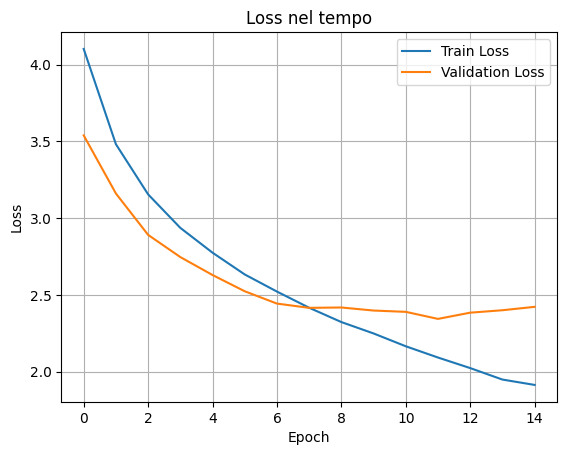

In [ ]:
# Loss plot
plot_loss(history1)

La loss sui dati di training diminuisce costantemente con l'aumentare delle epoche. Questo dovrebbe essere un buon segno, indicando che il modello sta imparando e riducendo l'errore sui dati visti durante l'addestramento.

La loss sui dati di validazione diminuisce inizialmente in modo simile alla training loss, ma poi tende a stabilizzarsi e inizia a risalire leggermente intorno all'epoca 8.

Il plot della loss, in combinazione con il plot dell'accuracy, rafforza l'idea di un sovra-apprendimento del modello. La convergenza iniziale di entrambe le curve suggerisce che il modello sta apprendendo efficacemente. Tuttavia, il punto in cui la Validation Loss smette di diminuire e inizia a risalire mentre la Train Loss continua a scendere, è proprio il segnale evidente di overfitting: il modello sta diventando troppo specifico per i dati di training, perdendo la sua capacità di generalizzare bene su dati non ancora visti.

Valutiamo adesso il modello sul set di dati di test completamente nuovo e mai visto durante l'addestramento.
Le performance finali del modello sono solitamente espresse dai valori di Test Loss e Test Accuracy. La Test Loss indica l'errore medio del modello sul set di dati di test con cui il modello non ha mai interagito prima; la Test Accuracy indica la percentuale di volte in cui il modello ha fatto la previsione corretta sul set di test. In generalem un valore di loss basso è sempre preferibile, così come un'accuracy più alta è desiderabile.

In [ ]:
# ==================================================
# Test
# ==================================================

#test_loss1, test_acc1 = history1.model.evaluate(x_test_norm, y_test)
test_loss1, test_acc1 = model1.evaluate(x_test_norm, y_test)
print(f"\nRisultati Modello 1:")
print(f"Test Loss: {test_loss1:.4f}")
print(f"Test Accuracy: {test_acc1:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4064 - loss: 2.3435

Risultati Modello 1:
Test Loss: 2.3457
Test Accuracy: 0.4002



Il modello ottiene valori di Test Loss pari a 2.2934 e Test Accuracy pari a circa il 41%. Confrontando questi risultati con i plot di "Accuracy nel tempo" e "Loss nel tempo", si può dire che c'è coerenza con le curve di validazione dei plot. Si ottengono infatti valori molto simili ai valori finali raggiunti dalle curve di validazione nei plot: la Validation Loss si aggira intorno a 2.4 e la Validation Accuracy intorno a 0.39-0.40. Ciò indica che il set di validazione ha fornito una stima realistica delle prestazioni del modello su dati nuovi.
Inoltre, poiché la Training Accuracy era più alta (circa 45%) e la Training Loss più bassa (circa 2.00) rispetto ai valori di test/validazione, questi risultati finali sul Test Set confermano l'overfitting: il modello si comporta peggio su dati non visti rispetto a quelli di training.

In conclusione, i livelli di performance finali ottenuti dal modello sono bassi, il che suggerisce che il modello scelto per questo tipo di dataset è troppo semplice, non cattura bene la complessità dei dati.
Tuttavia, essendo un modello iniziale, le prestazioni raggiunte possono considerarsi buone e costituiscono una base solida per ulteriori miglioramenti tramite tuning.


## Modello 2: CNN con Data Augmentation

In questo secondo esperimento, si apportano due modifiche principali al modello originale: aggiunta di data augmentation e tuning di alcuni iperparametri.

Per la Data Augmentation, viene introdotta una pipeline di trasformazioni casuali (flip orizzontale, rotazione, zoom) tramite keras.Sequential. Questo ha lo scopo di aumentare la diversità dei dati di input, riducendo il rischio di overfitting e migliorando la capacità di generalizzazione del modello.

La rete mantiene la struttura a 3 blocchi convoluzionali + max pooling, ma viene ridotto il numero di neuroni nel fully connected layer da 256 a 128 per semplificare il modello.

Viene modificato il learning rate (impostato manualmente a 0.0005), impostandolo ad un valore più basso rispetto al default di Adam (0.001). Questo consente aggiornamenti più stabili e può aiutare a migliorare la convergenza.

Inoltre, il numero di epoche viene aumentato a 40, mantenendo EarlyStopping sempre attivo, per dare spazio a un eventuale apprendimento più lento causato dal data augmentation.


In [ ]:
# ==================================================
# Data Augmentation
# ==================================================
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'), # Flip orizzontale casuale
    layers.RandomRotation(0.1),      # Rotazione casuale ±10%
    layers.RandomZoom(0.1),          # Zoom casuale ±10%
])

# ==================================================
# Model Definition
# ==================================================
def create_cnn_with_augmentation():
  model = keras.Sequential([

      keras.Input(shape=(32, 32, 3)),
      data_augmentation,

      layers.Conv2D(32, 3, activation='relu'),
      layers.MaxPooling2D(),

      layers.Conv2D(64, 3, activation='relu'),
      layers.MaxPooling2D(),

      layers.Conv2D(128, 3, activation='relu'),
      layers.MaxPooling2D(),

      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dropout(0.5),  # regolarizzazione
      layers.Dense(len(class_names), activation='softmax')
  ])
  return model


In [ ]:
# ==================================================
#  Model Compilation
# ==================================================

print("\n" + "="*50)
print("MODELLO 2: CNN CON DATA AUGMENTATION")
print("="*50)

model2 = load_model("model2.pkl")

if model2 is None:
  print("model2 None")
  model2 = create_cnn_with_augmentation()
  model2.compile(
      optimizer=keras.optimizers.Adam(learning_rate=0.0005),
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy']
  )
  # salvataggio modello base
  joblib.dump(model2, model_path + 'model2.pkl')

print("Architettura del Modello 2:")
model2.summary()


MODELLO 2: CNN CON DATA AUGMENTATION
Modello non trovato in:  /content/drive/MyDrive/model2.pkl
model2 None
Architettura del Modello 2:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        12,900 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171,812 (671.14 KB)

 Trainable params: 171,812 (671.14 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# ==================================================
#  Model Training
# ==================================================

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history2 = load_model("history2.pkl")
if history2 is None:
  print("history2 None")
  # Training del modello (EarlyStopping mantenuto)
  print("\nInizio training Modello 2...")
  history2 = model2.fit(x_train_norm, y_train,
                      batch_size=64,
                      epochs=40,
                      validation_split=0.1,
                      callbacks=[early_stop])
  # salvataggio history e modello addestrato
  joblib.dump(history2, model_path + 'history2.pkl')
  joblib.dump(model2, model_path + 'model2.pkl') #sovrascrive modello base



Modello non trovato in:  /content/drive/MyDrive/history2.pkl
history2 None

Inizio training Modello 2...
Epoch 1/40
704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.0270 - loss: 4.4689 - val_accuracy: 0.0890 - val_loss: 4.0002
Epoch 2/40
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.0831 - loss: 4.0269 - val_accuracy: 0.1270 - val_loss: 3.7605
Epoch 3/40
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.1176 - loss: 3.7931 - val_accuracy: 0.1474 - val_loss: 3.6018
Epoch 4/40
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.1354 - loss: 3.6483 - val_accuracy: 0.1796 - val_loss: 3.4627
Epoch 5/40
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.1562 - loss: 3.5444 - val_accuracy: 0.1942 - val_loss: 3.3749
Epoch 6/40
704/704 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.1675 - loss: 3.4698 - val_accuracy: 0.2040 - val_loss: 3.3390
Epoch 7/40
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.1861 - loss: 3.3930 - val_accuracy: 0.2140 - val_loss: 3.272

L’andamento dell’addestramento mostra alcune differenze rispetto al primo modello. L'accuracy di training cresce lentamente, raggiungendo circa il 31%.
L'accuracy di validazione si mantiene stabile intorno al 34%, con lievi oscillazioni senza miglioramenti netti oltre questo valore.
La val_loss mostra una diminuzione molto lenta, con valori che si stabilizzano intorno a 2.6.

In generale, la data augmentation ha aumentato la complessità del compito per il modello, essendo ora esposto a immagini leggermente variate; questo rallenta l’apprendimento ma dovrebbe favorire una migliore generalizzazione a lungo termine.
La riduzione del learning rate a 0.0005 rallenta i progressi iniziali, poiché i pesi si aggiornano in modo più conservativo.
La combinazione di questi fattori causa un apprendimento più lento e una precisione leggermente inferiore rispetto al primo modello nelle prime 17 epoche.

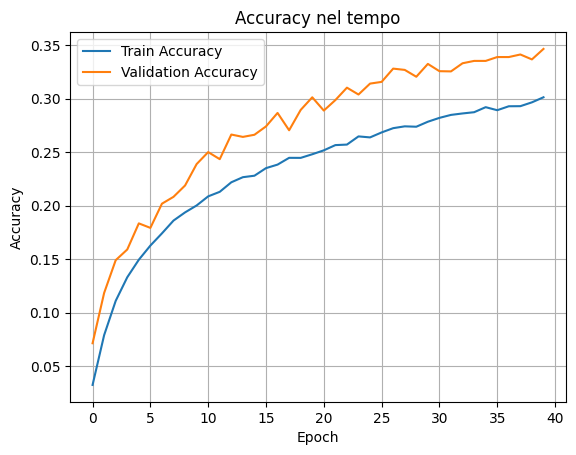

In [ ]:
# Accuracy plot
plot_accuracy(history2)

L'accuracy sui dati di training aumenta progressivamente con l'aumentare delle epoche, mentre sui dati di validazione aumenta in modo simile o addirittura superiore rispetto alla train accuracy per gran parte dell'addestramento, specialmente verso le epoche finali.
Nonostante l'andamento positivo, i valori assoluti di accuracy si aggirano intorno al 30-35% finale e sono relativamente bassi. Ciò suggerisce che, anche se il modello sta imparando, potrebbe non essere abbastanza potente o i dati potrebbero essere intrinsecamente complessi per ottenere un'accuracy molto elevata con questa configurazione.

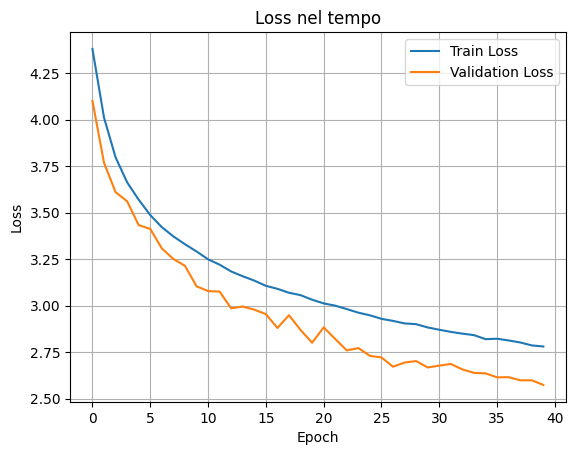

In [ ]:
# Loss plot
plot_loss(history2)

Dal plot si vede come la loss sui dati di training diminuisce costantemente nel corso delle epoche, indice che il modello sta imparando e riducendo l'errore sul set di addestramento.

Anche la loss sui dati di validazione diminuisce durante l'addestramento. Si possono notare alcune piccole fluttuazioni; nonostante ciò, si può dire che la tendenza generale è al ribasso e la curva rimane vicina alla curva di train loss.

A differenza del modello precedente, questo modello sembra dover necessitare di un addestramento più lungo. Sia le curve di loss che di accuracy sembrano non essere completamente assestate: le loss potrebbero ancora diminuire e quelle di accuracy aumentare, ovvero il modello potrebbe beneficiare di un addestramento più lungo su più epoche per imparare di più.
Le curve di training e validation loss sono vicine tra loro e entrambe in diminuzione, mentre le curve di accuracy sono entrambe in aumento e anch'esse vicine. Non c'è un punto chiaro in cui la validation loss inizia ad aumentare o la validation accuracy si stabilizza mentre la train accuracy continua a salire rapidamente. Questo indica che il modello non mostra più un comportamento di overfitting.





In [ ]:
# ==================================================
#  Test
# ==================================================
test_loss2, test_acc2 = model2.evaluate(x_test_norm, y_test)
print(f"\nRisultati Modello 2:")
print(f"Test Loss: {test_loss2:.4f}")
print(f"Test Accuracy: {test_acc2:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3482 - loss: 2.5507

Risultati Modello 2:
Test Loss: 2.5484
Test Accuracy: 0.3460


Guardando le metriche di performance ottenute sul set di dati di test, i risultati sono in linea ai valori finali di Validation Loss e Validation Accuracy osservati nei plot. Questo indica che i valori di test sono coerenti con le curve di validazione e non mostrano peggioramenti significativi. Il modello non sembra soffrire di overfitting adesso, altrimenti la Test Loss sarebbe probabilmente più alta e la Test Accuracy più bassa rispetto ai valori di validazione. Tuttavia, l'accuracy ottenuta sul test set è ancora bassa; il modello ha margini di miglioramento e le performance potrebbero essere ottimizzate, ad esempio prolungando il numero di epoche.  

Nel complesso, questo secondo modello appare più robusto e meno incline all’overfitting (non mostra miglioramenti rapidi seguiti da peggioramenti), ma necessita di più epoche o ulteriori ottimizzazioni per superare le prestazioni iniziali del primo modello. Si potrebbe provare a continuare l'addestramento. aumentando il numero di epoche, o a rendere il modello più complesso con più strati, per vedere se riesce a catturare meglio i pattern nei dati e se le performance migliorano così ulteriormente.


Proviamo ad introdurre architetture più complesse per poter raggiungere valori più soddisfacenti di accuracy.




## Modello 3: CNN con Batch Normalization e Learning Scheduler

In questo modello viene utilizzata una rete più profonda aggiungendo due layer convoluzionali (256 e 512 filtri) per aumentare la capacità espressiva del modello.

Inoltre si aggiunge, dopo ogni convoluzione, batch normalization per normalizzare l’output prima dell’attivazione, al fine di stabilizzare e accelerare l’apprendimento.

Si introduce poi ReduceLROnPlateau che riduce dinamicamente il learning rate quando la val_loss si blocca, facilitando la convergenza.

Infine, viene mantenuto EarlyStopping ma con pazienza più alta (7 epoche) al fine di garantire al modello più profondo un tempo maggiore.

In [ ]:
# ==================================================
#  Model Definition
# ==================================================
def create_advanced_cnn():
  model = keras.Sequential([
      keras.Input(shape=(32, 32, 3)),
      data_augmentation,

      layers.Conv2D(32, 3, padding='same'),
      layers.BatchNormalization(),
      layers.Activation('relu'),
      layers.MaxPooling2D(),

      layers.Conv2D(64, 3, padding='same'),
      layers.BatchNormalization(),
      layers.Activation('relu'),
      layers.MaxPooling2D(),

      layers.Conv2D(128, 3, padding='same'),
      layers.BatchNormalization(),
      layers.Activation('relu'),
      layers.MaxPooling2D(),

      # Aumentiamo la profondità con due layer Conv aggiuntivi
      layers.Conv2D(256, 3, padding='same'),
      layers.BatchNormalization(),
      layers.Activation('relu'),
      layers.MaxPooling2D(),

      layers.Conv2D(512, 3, padding='same'),
      layers.BatchNormalization(),
      layers.Activation('relu'),
      layers.MaxPooling2D(),

      layers.Flatten(),
      layers.Dense(256, activation='relu'),
      layers.Dropout(0.5),
      layers.Dense(len(class_names), activation='softmax')
  ])
  return model

In [ ]:
# ==================================================
#  Model Compilation
# ==================================================

print("\n" + "="*50)
print("MODELLO 3: CNN CON BATCH NORMALIZATION E LR SCHEDULER")
print("="*50)

model3 = load_model("model3.pkl")

if model3 is None:
  print("model3 None")
  model3 = create_advanced_cnn()
  model3.compile(
      optimizer=keras.optimizers.Adam(learning_rate=0.0005),
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy']
  )
  # salvataggio modello base
  joblib.dump(model3, model_path + 'model3.pkl')

print("Architettura del Modello 3:")
model3.summary()

# Callback per ridurre il LR quando la validazione si blocca
lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,    # Riduce LR della metà
    patience=3,    # Aspetta 3 epoche senza miglioramento
    verbose=1,
    min_lr=1e-6
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1
)




MODELLO 3: CNN CON BATCH NORMALIZATION E LR SCHEDULER
Modello non trovato in:  /content/drive/MyDrive/model3.pkl
model3 None
Architettura del Modello 3:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 2, 2, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 2, 2, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,729,572 (6.60 MB)

 Trainable params: 1,727,588 (6.59 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [ ]:
# ==================================================
# Model Training
# ==================================================

history3 = load_model("history3.pkl")

if history3 is None:
  print("\nInizio training Modello 3...")
  history3 = model3.fit(
      x_train_norm, y_train,
      batch_size=64,
      epochs=40,
      validation_split=0.1,
      callbacks=[lr_scheduler, early_stopping]
  )
  # salvataggio history e modello addestrato
  joblib.dump(history3, model_path + 'history3.pkl')
  joblib.dump(model3, model_path + 'model3.pkl') #sovrascrive modello base

Modello non trovato in:  /content/drive/MyDrive/history3.pkl

Inizio training Modello 3...
Epoch 1/40
704/704 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.0379 - loss: 4.4751 - val_accuracy: 0.1036 - val_loss: 3.8746 - learning_rate: 5.0000e-04
Epoch 2/40
704/704 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.0954 - loss: 3.9103 - val_accuracy: 0.1658 - val_loss: 3.4935 - learning_rate: 5.0000e-04
Epoch 3/40
704/704 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.1307 - loss: 3.6621 - val_accuracy: 0.1884 - val_loss: 3.3649 - learning_rate: 5.0000e-04
Epoch 4/40
704/704 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.1564 - loss: 3.4941 - val_accuracy: 0.2212 - val_loss: 3.1270 - learning_rate: 5.0000e-04
Epoch 5/40
704/704 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.1811 - loss: 3.3723 - val_accuracy: 0.2520 - val_loss: 2.9813 - learning_rate: 5.0000e-04
Epoch 6/40
704/704 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.2010 - loss: 3.2525 - val_accuracy: 0.2832 - val_lo

Questo modello, grazie all'introduzione di un'architettura più profonda con Batch Normalization e l'implementazione di uno scheduler di learning rate (ReduceLROnPlateau) insieme a EarlyStopping con maggiore pazienza, mostra un notevole miglioramento nella stabilità dell'addestramento.

Le strategie implementate svolgono un ruolo cruciale nei miglioramenti di questo modello. Il fatto di avere una rete più profonda con l'aggiunta di due layer convoluzionali con profondità crescente (fino a 512 filtri), permette al modello di avere una maggiore capacità espressiva, così da catturare ed apprendere rappresentazioni più complesse e astratte delle immagini. L’introduzione della Batch Normalization accelera l'apprendimento, come si può vedere dai valori di accuracy e loss e dalla capacità del modello di mantenere un learning rate relativamente alto all'inizio. Lo scheduler ReduceLROnPlateau sembra essere efficace nel ridurre il learning rate, che risulta dimezzato una prima volta verso metà addestramento da 5.0000e−04 a 2.5000e−04 e poi ulteriormente nelle epoche successive. Queste riduzioni permettono al modello di affinare l'apprendimento e di convergere ulteriormente. Infine, l' EarlyStopping con pazienza più alta (7 epoche) fa sì che il modello, essendo più profondo e complesso, abbia tempo sufficiente per apprendere prima che l'addestramento venga interrotto. Dall'output, la migliore epoca è stata la 39, per cui vengono ripristinati i pesi da quell'epoca.

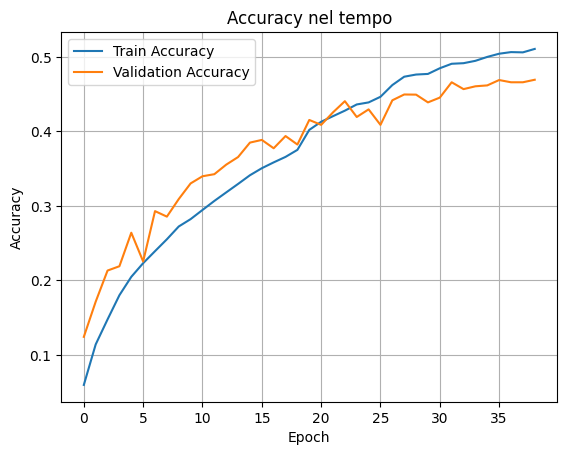

In [ ]:
# Accuracy plot
plot_accuracy(history3)

Dal plot si può osservare che la Train Accuracy aumenta costantemente, raggiungendo circa lo 0.50 alla fine dell'addestramento.
Anche la Validation Accuracy aumenta in modo robusto e rimane molto vicina alla Train Accuracy per la maggior parte del tempo. Dopo l'epoca 30, la Validation Accuracy raggiunge un picco di circa 0.47 e poi mostra leggere fluttuazioni, mentre la Train Accuracy continua a salire leggermente.
L'accuracy di validazione segue un percorso simile a quella di training, rimanendo molto vicina a quest'ultima. Questo stretto allineamento tra le due curve indica una buona capacità di generalizzazione e l'assenza di overfitting significativo.

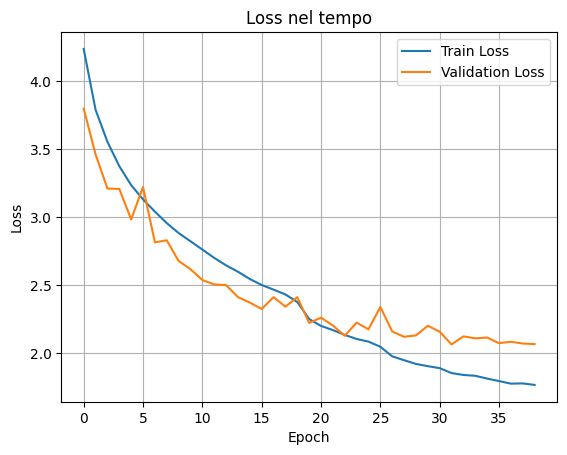

In [ ]:
# Loss plot
plot_loss(history3)

La Train Loss diminuisce in maniera continua e progressiva, arrivando a circa 1.8 alla fine. Anche la Validation Loss diminuisce in modo significativo e segue da vicino la Train Loss. La Validation Loss mostra qualche fluttuazione, mantenendosi comunque in un intervallo simile alla Train Loss, senza il netto aumento che si è osservato nel modello 1. Non si osservano infatti aumenti repentini o divergenze marcate, il che è un segno positivo della stabilità dell'addestramento e di una buona gestione dell'overfitting, cosa che non avveniva nel modello 1.

In [ ]:
# ==================================================
# Test
# ==================================================
test_loss3, test_acc3 = model3.evaluate(x_test_norm, y_test)
print(f"\nRisultati Modello 3:")
print(f"Test Loss: {test_loss3:.4f}")
print(f"Test Accuracy: {test_acc3:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4813 - loss: 1.9924

Risultati Modello 3:
Test Loss: 2.0094
Test Accuracy: 0.4805


L’addestramento di questo terzo modello mostra progressi significativi rispetto ai tentativi precedenti ed i risultati finali sul test set confermano il netto miglioramento di questo modello. I valori ottenuti sono significativamente migliori rispetto ai modelli precedenti. La Test Accuracy di quasi il 49% è molto vicina al picco di Validation Accuracy (0.4694 all'epoca 39), e la Test Loss è anch'essa coerente con la Validation Loss finale. Questo dimostra che il modello 3 ha raggiunto una notevole capacità di generalizzazione su dati non visti e ha gestito efficacemente l'overfitting.

Il modello 3 rappresenta quindi un netto avanzamento, evidenziando come l'introduzione mirata di architetture più complesse e tecniche di regolarizzazione e ottimizzazione avanzate sia cruciale per migliorare le performance e la stabilità.

## Modello 4: ResNet-18

Nel tentativo di migliorare ulteriormente le prestazioni del modello, introduciamo una ResNet* (Residual Network), in quanto questo tipo di architettura ha la capacità di addestrare reti molto profonde senza incorrere nel problema del degrado delle performance.

Il problema del "Degrading Accuracy" si verifica quando reti più profonde tendono a peggiorare nelle prestazioni, anzichè migliorare. Questo non è causato da overfitting, ma da difficoltà nell’ottimizzazione.

La ResNet risolve questo problema introducendo i residual blocks, ovvero dei blocchi che permettono al segnale di "saltare" uno o più layer tramite una connessione diretta (skip connection).

In questo scenario, se la rete non riesce a migliorare l'output, almeno può lasciarlo invariato, evitando peggioramenti.

Nel contesto del dataset CIFAR-100, caratterizzato da immagini piccole ma con molte classi (100), la profondità e stabilità di una ResNet possono essere vantaggiose.

Per iniziare, si procede con l'implementazione di una versione semplificata e adattata della ResNet-18, adatta alle dimensioni ridotte delle immagini 32x32. Il modello sfrutta blocchi residui con Batch Normalization, ReLU e Add, per massimizzare la stabilità e la capacità di apprendimento.


**Fonte: "Deep Residual Learning for Image Recognition", Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun, https://arxiv.org/abs/1512.03385*

In [ ]:
# ==================================================
# Residual Block
# ==================================================
def residual_block(x, filters, stride=1):
    shortcut = x
    x = layers.Conv2D(filters, kernel_size=3, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

In [ ]:
# ==================================================
# Build ResNet-18
# ==================================================
def build_resnet18(input_shape=(32,32,3), num_classes=100):

    inputs = layers.Input(input_shape)

    # Inizializzazione
    x = layers.Conv2D(64, kernel_size=3, strides=1, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Blocchi residui
    filters = [64, 128, 256, 512]
    strides = [1, 2, 2, 2]
    for f, s in zip(filters, strides):
        x = residual_block(x, f, stride=s)
        x = residual_block(x, f, stride=1)

    # Classificazione
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    return keras.Model(inputs, x)

In [ ]:
# ==================================================
#  Model Compilation
# ==================================================

print("\n" + "="*50)
print("MODELLO 4: RESNET-18")
print("="*50)

model4 = load_model("model4.pkl")

if model4 is None:
  print("model4 None")
  model4 = build_resnet18()
  model4.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy']
  )
  # salvataggio modello base
  joblib.dump(model4, model_path + 'model4.pkl')

print("Architettura del Modello 4 (ResNet-18):")
model4.summary()


MODELLO 4: RESNET-18
Modello non trovato in:  /content/drive/MyDrive/model4.pkl
model4 None
Architettura del Modello 4 (ResNet-18):


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 32, 32,    │      1,792 │ input_layer_6[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_47[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_33 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_48 (Conv2D)  │ (None, 32, 32,    │     36,928 │ re_lu_33[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_48[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_34 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_49 (Conv2D)  │ (None, 32, 32,    │     36,928 │ re_lu_34[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_49[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ re_lu_33[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_35 (ReLU)     │ (None, 32, 32,    │          0 │ add_16[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_50 (Conv2D)  │ (None, 32, 32,    │     36,928 │ re_lu_35[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_50[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_36 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_51 (Conv2D)  │ (None, 32, 32,    │     36,928 │ re_lu_36[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_51[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, 32, 32,    │          0 │ batch_normalizat

 Total params: 11,234,532 (42.86 MB)

 Trainable params: 11,224,932 (42.82 MB)

 Non-trainable params: 9,600 (37.50 KB)

In [ ]:
# ==================================================
#  Model Compilation
# ==================================================

history4 = load_model("history4.pkl")

if history4 is None:
  print("\nInizio training Modello 4 (ResNet-18)...")
  history4 = model4.fit(
      x_train_norm, y_train,
      batch_size=64,
      epochs=30,
      validation_split=0.1,
      callbacks=[
          keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
          keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2, min_lr=1e-6),
      ]
  )
  # salvataggio history e modello addestrato
  joblib.dump(history4, model_path + 'history4.pkl')
  joblib.dump(model4, model_path + 'model4.pkl')


Modello non trovato in:  /content/drive/MyDrive/history4.pkl

Inizio training Modello 4 (ResNet-18)...
Epoch 1/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 92s 96ms/step - accuracy: 0.1138 - loss: 3.9422 - val_accuracy: 0.1162 - val_loss: 4.9930 - learning_rate: 0.0010
Epoch 2/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 54s 77ms/step - accuracy: 0.3047 - loss: 2.7359 - val_accuracy: 0.2756 - val_loss: 3.4486 - learning_rate: 0.0010
Epoch 3/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 54s 76ms/step - accuracy: 0.4416 - loss: 2.0806 - val_accuracy: 0.3180 - val_loss: 3.3037 - learning_rate: 0.0010
Epoch 4/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 84s 79ms/step - accuracy: 0.5528 - loss: 1.5986 - val_accuracy: 0.3348 - val_loss: 3.2676 - learning_rate: 0.0010
Epoch 5/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 81s 78ms/step - accuracy: 0.6627 - loss: 1.1703 - val_accuracy: 0.3212 - val_loss: 3.7656 - learning_rate: 0.0010
Epoch 6/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 54s 77ms/step - accuracy: 0.7719 - loss: 0.7697 - val_accuracy: 0.3760 - val_loss: 3.48

Questo modello, basato su una ResNet-18 semplificata, raggiunge una elevata accuracy sul training set in poche epoche. Un valore quasi pari al 100% suggerisce un probabile comportamento di overfitting.

L'implementazione di una versione adattata della ResNet-18 con blocchi residui, Batch Normalization, ReLU e Add è progettata per massimizzare stabilità e capacità di apprendimento. Tuttavia, in questo caso, la capacità espressiva della ResNet-18, anche se adattata per immagini 32x32, sembra essere troppo elevata per la quantità di dati disponibili o per la loro complessità intrinseca. Il modello finisce con il memorizzare il training set. Batch Normalization e ReLU migliorano la stabilità e la convergenza, ma non sono tecniche di regolarizzazione che riescono a prevenire l'overfitting. L'assenza di meccanismi di regolarizzazione espliciti, come il dropout e la regolarizzazione L1/L2, ed un valore di patience probabilmente non ottimale per l'early stopping, influiscono sull'overfitting. Questi parametri necessitano di un tuning migliore.

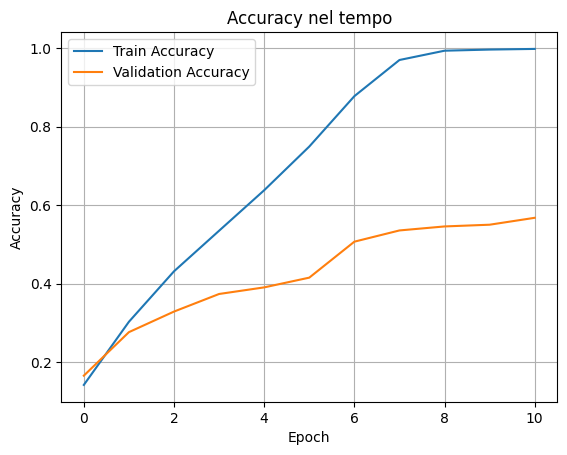

In [ ]:
# Accuracy plot
plot_accuracy(history4)

Dal plot si osserva un forte divario tra le due curve. L'accuracy sul training set sale molto rapidamente, raggiungendo quasi il 100% (intorno a 0.99) in poche epoche. Questo indica che il modello sta imparando a classificare perfettamente i dati di addestramento, potenziale segnale di overfitting.
L'accuracy sul validation set aumenta inizialmente, ma poi si stabilizza intorno a 0.50−0.55 a partire dall'epoca 7, con delle piccole fluttuazioni. C'è un ampio divario crescente tra la train accuracy e la validation accuracy, che è il segnale più evidente di overfitting.

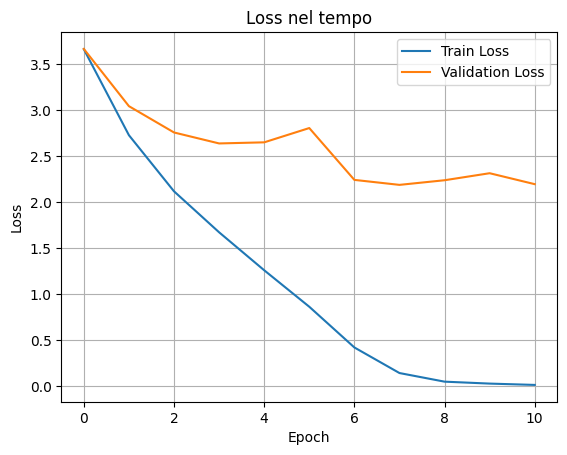

In [ ]:
# Loss plot
plot_loss(history4)

Il plot mostra che la loss sul training set diminuisce drasticamente, scendendo quasi a zero in sole 9 epoche. Questo riflette il fatto che il modello sta minimizzando l'errore sui dati di addestramento.

La loss sul validation set, dopo un iniziale calo, inizia a salire e fluttuare dopo l'epoca 5. Mentre la train loss continua a scendere vertiginosamente, la validation loss fluttua aumentando e diminuendo, ma rimanendo sempre al di sopra della training loss. Questo crea una divergenza significativa tra le due curve, altro forte indicatore di overfitting: il modello sta diventando troppo specifico per i dati di training e non riesce a generalizzare bene a nuovi dati.

In [ ]:
# ==================================================
# Test
# ==================================================
test_loss4, test_acc4 = model4.evaluate(x_test_norm, y_test)
print(f"\nRisultati Modello 4 (ResNet-18):")
print(f"Test Loss: {test_loss4:.4f}")
print(f"Test Accuracy: {test_acc4:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.5284 - loss: 2.2078

Risultati Modello 4 (ResNet-18):
Test Loss: 2.1888
Test Accuracy: 0.5266


Le performance finali sul set di test sono:

- Test Loss: 2.1888
- Test Accuracy: 0.5266 (52.66%)

Questi risultati confermano il comportamento osservato nei grafici. In particolare, la Test Accuracy (52.66%) è molto vicina alla Validation Accuracy (54% raggiunta all'epoca 9) e la Test Loss (2.1888) è anch'essa in linea con la Validation Loss finale (2.1975).

La ResNet18 mostra un’eccellente capacità di apprendimento, raggiungendo oltre il 99% di accuratezza sul training set e più del 50% sul test set, migliorando significativamente rispetto ai modelli precedenti. Tuttavia, il confronto con la Train Accuracy (quasi 100%) evidenzia un enorme divario nelle prestazioni: il modello eccelle sui dati visti, ma ha difficoltà a generalizzare.
In altre parole, il forte divario tra training e validation suggerisce che il modello 4 soffre di grave overfitting. Sebbene l'accuracy sul training set sia quasi perfetta, la sua capacità di generalizzazione è limitata, come dimostrato dalla Test Accuracy di circa 50%.

Complessivamente, la ResNet può essere potenzialmente una scelta efficace, a condizione che vengano applicati ulteriori tuning e miglioramenti. Per migliorare questo modello, è necessario ricorrere a strategie di regolarizzazione per prevenire l'overfitting, quali ad esempio dropout, regolarizzazione L1/L2 e data Augmentation in modo da generare più esempi di training ed avere così una maggiore variabilità.

## Modello 5: ResNet-34 + Data Augmentation + Regolarizzazione e Dropout

Dopo i risultati ottenuti con ResNet-18, ricorrimao ad una ResNet-34, una variante più profonda della rete residua, in grado di apprendere rappresentazioni più complesse grazie al numero maggiore di blocchi. Il meccanismo delle skip connections rimane fondamentale per prevenire la degradazione del gradiente nei livelli profondi.

Per migliorare la capacità di generalizzazione e prevenire l'overfitting osservato nel modello precedente, conviene introdurre un modulo di data augmentation con trasformazioni casuali (flip, rotazioni, zoom e contrasto), Dropout e regularizzazione L2 nei blocchi residui.

In [ ]:
# ==================================================
# Data Augmentation
# ==================================================
enhanced_data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

# ==================================================
# Residual Block with L2 e Dropout
# ==================================================
def enhanced_residual_block(x, filters, stride=1, weight_decay=1e-4, dropout_rate=0.3):
    shortcut = x
    x = layers.Conv2D(filters, kernel_size=3, strides=stride, padding='same',
                      kernel_regularizer=regularizers.l2(weight_decay))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout_rate)(x)  # Dropout nel residuo

    x = layers.Conv2D(filters, kernel_size=3, padding='same',
                      kernel_regularizer=regularizers.l2(weight_decay))(x)
    x = layers.BatchNormalization()(x)

    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same',
                                 kernel_regularizer=regularizers.l2(weight_decay))(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

In [ ]:
# ==================================================
# Build ResNet-34 with Dropout and L2
# ==================================================
def build_resnet34(input_shape=(32,32,3), num_classes=100, dropout_rate=0.3, weight_decay=1e-4):
    inputs = layers.Input(input_shape)
    x = enhanced_data_augmentation(inputs)
    x = layers.Conv2D(64, kernel_size=3, strides=1, padding='same',
                      kernel_regularizer=regularizers.l2(weight_decay))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    num_blocks = [3, 4, 6, 3]
    filters = [64, 128, 256, 512]
    strides = [1, 2, 2, 2]

    for nb, f, s in zip(num_blocks, filters, strides):
        for i in range(nb):
            stride = s if i == 0 else 1
            x = enhanced_residual_block(x, f, stride, weight_decay, dropout_rate)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(weight_decay))(x)

    return keras.Model(inputs, outputs)

In [ ]:
# ==================================================
#  Model Compilation
# ==================================================

print("\n" + "="*50)
print("MODELLO 5: RESNET-34 CON REGOLARIZZAZIONE AVANZATA")
print("="*50)

model5 = load_model("model5.pkl")

if model5 is None:
  print("model5 None")
  model5 = build_resnet34()
  model5.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy']
  )
  # salvataggio modello base
  joblib.dump(model5, model_path + 'model5.pkl')

print("Architettura del Modello 5 (ResNet-34):")
model5.summary()


MODELLO 5: RESNET-34 CON REGOLARIZZAZIONE AVANZATA
Modello non trovato in:  /content/drive/MyDrive/model5.pkl
model5 None
Architettura del Modello 5 (ResNet-34):


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 32, 32, 3) │          0 │ input_layer[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │      1,792 │ sequential[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │     36,928 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32, 32,    │          0 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     36,928 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 32, 32,    │          0 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │     36,928 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32, 32,    │          0 │ re_lu_3[0][0]   

 Total params: 21,353,828 (81.46 MB)

 Trainable params: 21,336,804 (81.39 MB)

 Non-trainable params: 17,024 (66.50 KB)

In [ ]:
# ==================================================
#  Model Training
# ==================================================

history5 = load_model("history5.pkl")

if history5 is None:
  print("\nInizio training Modello 5 (ResNet-34)...")
  history5 = model5.fit(
      x_train_norm, y_train,
      batch_size=64,
      epochs=30,
      validation_split=0.1,
      callbacks=[
          keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
          keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6),
      ]
  )
  # salvataggio history e modello addestrato
  joblib.dump(history5, model_path + 'history5.pkl')
  joblib.dump(model5, model_path + 'model5.pkl') #sovrascrive modello base


Modello non trovato in:  /content/drive/MyDrive/history5.pkl

Inizio training Modello 5 (ResNet-34)...
Epoch 1/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 167s 192ms/step - accuracy: 0.0431 - loss: 5.4059 - val_accuracy: 0.0900 - val_loss: 7.5846 - learning_rate: 0.0010
Epoch 2/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 135s 189ms/step - accuracy: 0.1272 - loss: 4.2258 - val_accuracy: 0.1458 - val_loss: 4.2449 - learning_rate: 0.0010
Epoch 3/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 135s 191ms/step - accuracy: 0.1834 - loss: 3.8538 - val_accuracy: 0.1930 - val_loss: 4.1939 - learning_rate: 0.0010
Epoch 4/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 142s 192ms/step - accuracy: 0.2274 - loss: 3.6366 - val_accuracy: 0.2568 - val_loss: 3.5370 - learning_rate: 0.0010
Epoch 5/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 144s 194ms/step - accuracy: 0.2675 - loss: 3.4656 - val_accuracy: 0.2888 - val_loss: 3.4053 - learning_rate: 0.0010
Epoch 6/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 142s 194ms/step - accuracy: 0.3018 - loss: 3.3392 - val_accuracy: 0.3194 - va

Il modello 5 mostra un netto miglioramento nella capacità di apprendimento e nella generalizzazione, grazie all'architettura più profonda e all'introduzione di tecniche di regolarizzazione più robuste.

Le strategie implementate sembrano essere efficaci nel contrastare l'overfitting ed ottenere buone prestazioni. Il numero maggiore di blocchi e la profondità del modello permettono evidententemente di catturare rappresentazioni più complesse. Le skip connections aiutano nell'addestramento, consentendo di procedere in modo stabile anche con molti strati, come è dimostrato dalla capacità del modello di raggiungere accuracy più alte rispetto ai modelli precedenti. Una migliore generalizzazione di questo modello rispetto al precedente è resa possibile dalla Data Augmentation. I fattori di flip, rotazioni, zoom e contrasto introducono delle versioni leggermente modificate delle immagini di training, rendendo il modello più robusto e meno propenso a memorizzare esempi specifici, riducendo così l'overfitting. Anche le tecniche di regolarizzazione contribuiscono a prevenire l'overfitting. Il dropout forza il modello a non fare eccessivo affidamento su un singolo neurone, mentre la regolarizzazione L2 penalizza i pesi più grandi, propendendo per un modello più semplice e meno propenso a memorizzare il rumore nei dati di training.


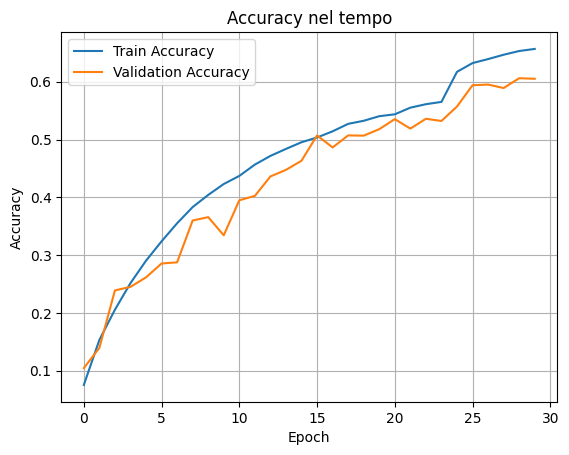

In [ ]:
# Accuracy plot
plot_accuracy(history5)

Il plot mostra un aumento costante e marcato della Train Accuracy,
partendo da circa 0.08 e raggiungendo quasi 0.65 all'epoca 30.

Anche la Validation Accuracy aumenta in modo significativo e, nonostante alcune fluttuazioni, rimane vicina alla curva della training accuracy, attestandosi intorno a 0.60 verso l'epoca 30. Non si osserva un divario crescente e divergente come nel caso dell'overfitting, indicando che il modello adesso sta generalizzando bene.

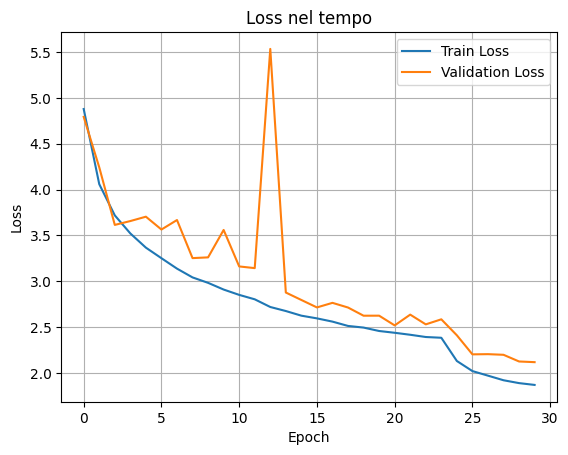

In [ ]:
# Loss plot
plot_loss(history5)

Dal plot si può osservare che la Train Loss diminuisce in modo costante e significativo, indicando che il modello sta imparando a ridurre l'errore sui dati di addestramento. La Validation Loss diminuisce anch'essa seguendo la train loss, tranne che per un picco anomalo intorno all'Epoch 12-13, forse dovuto ad una brusca variazione del learning rate, ad un batch particolarmente difficile da processare oppure ad una momentanea degradazione dell'uso delle risorse di calcolo. La tendenza generale è comunque al ribasso e la curva si mantiene relativamente vicina alla train loss per il resto dell'addestramento.

In [ ]:
# ==================================================
# Test
# ==================================================
test_loss5, test_acc5 = model5.evaluate(x_test_norm, y_test)
print(f"\nRisultati Modello 5 (ResNet-34):")
print(f"Test Loss: {test_loss5:.4f}")
print(f"Test Accuracy: {test_acc5:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.6126 - loss: 2.0968

Risultati Modello 5 (ResNet-34):
Test Loss: 2.0909
Test Accuracy: 0.6101


Il modello ResNet-34 raggiunge una accuratezza finale sul set di test pari superiore al 60%. I risultati ottenuti sono molto positivi e coerenti con l'andamento osservato nei plot. Durante l’addestramento si osserva infatti un progressivo miglioramento della accuratezza sia sul training che sulla validazione, con una curva di apprendimento regolare e stabile.
La Test Accuracy è significativamente più alta di tutti i modelli precedenti, indicando che il modello 5 ha appreso a classificare i dati non visti con una precisione maggiore. Questo valore è anche molto vicino alla Validation Accuracy finale, a dimostrazione di una robusta capacità di generalizzazione. La perdita di validazione e il valore di accuratezza su test sono coerenti, indicando che il modello è sufficientemente robusto.

L’utilizzo di tecniche di regolarizzazione quali la penalizzazione L2 (weight decay), il dropout e una strategia di data augmentation si rivelano efficaci nel contenere il fenomeno di overfitting, garantendo una buona generalizzazione. L’applicazione di un meccanismo di riduzione dinamica del learning rate ha permesso una convergenza più efficace, con un progressivo affinamento delle prestazioni nel corso delle epoche. Le curve di training e validation loss/accuracy si mantengono allineate e mostrano un miglioramento continuo, culminando in una performance finale sul set di test che si può ritenere buona.
L'unico punto di attenzione è il picco nella validation loss intorno all'epoca 12-13; tuttavia, il modello riesce poi a recuperare e a continuare l'apprendimento in modo stabile.

In conclusione, il modello sviluppato dimostra una buona capacità di apprendimento e generalizzazione nel riconoscimento di immagini appartenenti ad un ampio spettro di classi, costituendo quindi una solida base per futuri affinamenti.

# Riepilogo risultati

Per valutare l'efficacia delle diverse architetture e strategie di addestramento, analizziamo ora un riepilogo comparativo dei risultati e visualizziamo l'andamento di accuracy e loss per tutti i modelli finora proposti.

In [ ]:
# Visualizzazione dell'andamento del training (accuracy e loss) per tutti i modelli

def plot_training_history(histories, model_names, metric='accuracy'):

    plt.figure(figsize=(15, 10))

    # Subplot per accuracy
    plt.subplot(2, 2, 1)
    for i, (history, name) in enumerate(zip(histories, model_names)):
        plt.plot(history.history[metric], label=f'{name} - Train', linestyle='-')
        plt.plot(history.history[f'val_{metric}'], label=f'{name} - Val', linestyle='--')
    plt.title('Accuracy durante il Training')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Subplot per loss
    plt.subplot(2, 2, 2)
    for i, (history, name) in enumerate(zip(histories, model_names)):
        plt.plot(history.history['loss'], label=f'{name} - Train', linestyle='-')
        plt.plot(history.history['val_loss'], label=f'{name} - Val', linestyle='--')
    plt.title('Loss durante il Training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Subplot per accuracy finale
    plt.subplot(2, 2, 3)
    train_acc = [history.history[metric][-1] for history in histories]
    val_acc = [history.history[f'val_{metric}'][-1] for history in histories]

    x = np.arange(len(model_names))
    width = 0.35

    plt.bar(x - width/2, train_acc, width, label='Train Accuracy', alpha=0.8)
    plt.bar(x + width/2, val_acc, width, label='Validation Accuracy', alpha=0.8)

    plt.title('Accuracy Finale dei Modelli')
    plt.xlabel('Modelli')
    plt.ylabel('Accuracy')
    plt.xticks(x, model_names, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Subplot per loss finale
    plt.subplot(2, 2, 4)
    train_loss = [history.history['loss'][-1] for history in histories]
    val_loss = [history.history['val_loss'][-1] for history in histories]

    plt.bar(x - width/2, train_loss, width, label='Train Loss', alpha=0.8)
    plt.bar(x + width/2, val_loss, width, label='Validation Loss', alpha=0.8)

    plt.title('Loss Finale dei Modelli')
    plt.xlabel('Modelli')
    plt.ylabel('Loss')
    plt.xticks(x, model_names, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [ ]:
histories = [history1, history2, history3, history4, history5]
model_names = ['CNN Base', 'CNN + Data Augmentation', 'CNN + Batch Norm + LR Scheduler', 'ResNet-18', 'ResNet-34 + Regolarizzazione']

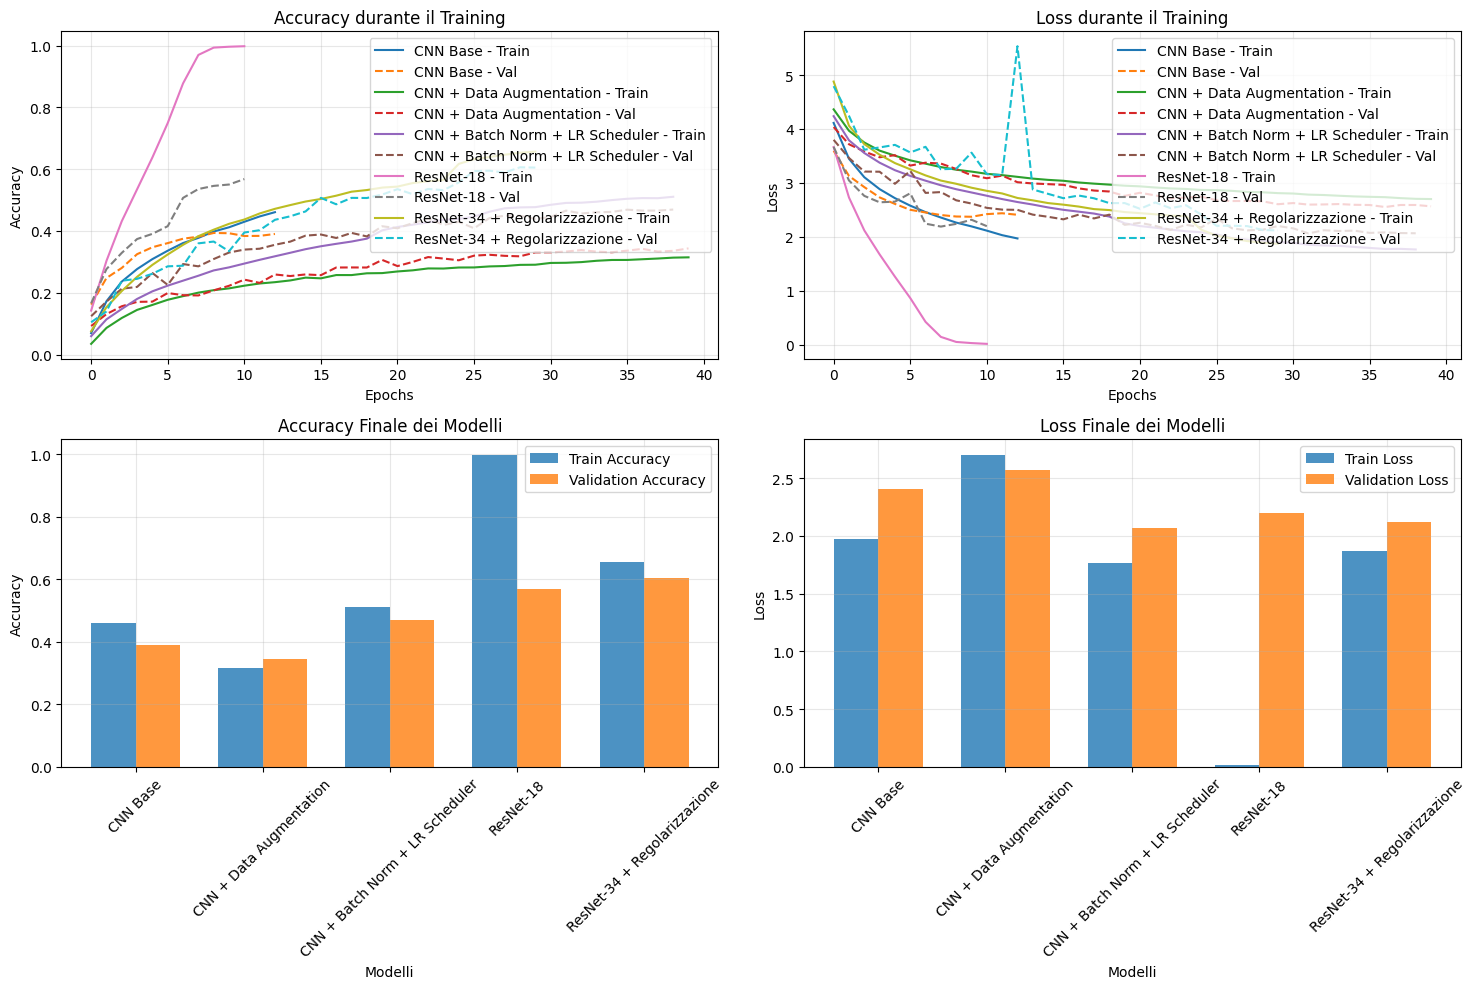

In [ ]:
# Visualizzazione dei risultati
plot_training_history(histories, model_names)

In [ ]:
# ==================================================
# RIEPILOGO RISULTATI
# ==================================================
"""
Tabella riassuntiva delle performance di tutti i modelli
"""
print("\n" + "="*70)
print("RIEPILOGO RISULTATI FINALI")
print("="*70)

results_df = pd.DataFrame({
    'Modello': [
        'CNN Base',
        'CNN + Data Augmentation',
        'CNN + Batch Norm + LR Scheduler',
        'ResNet-18',
        'ResNet-34 + Regolarizzazione'
    ],
    'Test Loss': [test_loss1, test_loss2, test_loss3, test_loss4, test_loss5],
    'Test Accuracy': [test_acc1, test_acc2, test_acc3, test_acc4, test_acc5],
    'Parametri': [
        model1.count_params(),
        model2.count_params(),
        model3.count_params(),
        model4.count_params(),
        model5.count_params()
    ]
})

print(results_df.to_string(index=False, float_format='%.4f'))


RIEPILOGO RISULTATI FINALI
                        Modello  Test Loss  Test Accuracy  Parametri
                       CNN Base     2.3312         0.4026     643492
        CNN + Data Augmentation     2.5246         0.3566     171812
CNN + Batch Norm + LR Scheduler     2.0094         0.4805    1729572
                      ResNet-18     2.1888         0.5266   11234532
   ResNet-34 + Regolarizzazione     2.0909         0.6101   21353828


Il plot e la tabella riepilogativa aiutano a riassumere le performance finali di ciascun modello sul set di test, evidenziando l'impatto delle diverse architetture e strategie di ottimizzazione.
In particolare:
- la CNN Base è il punto di partenza, con cui si ottiene un'accuracy moderata ed una loss che suggerisce un modello che ha ampi margini di miglioramento;

- il modello dato da CNN e Data Augmentation mostra performance peggiore e loss più alta. Ciò potrebbe indicare che le trasformazioni di data augmentation sono forse troppo aggressive o comunque non appropriate per il dataset specifico, oppure che la capacità del modello non è sufficiente per sfruttarle in modo efficace, portando ad un comportamento di underfitting. Da notare anche la riduzione dei parametri rispetto al CNN Base, il che potrebbe influenzare sulla minor capacità;

- il modello con CNN + Batch Normalization + LR Scheduler mostra un miglioramento significativo, grazie all'introduzione di Batch Normalization e Learning Rate Scheduler che stabilizzano e accelerano l'addestramento, permettendo così al modello di sfruttare meglio la sua capacità e di mitigare l'overfitting osservato in precedenza;

- l'adozione di un'architettura più complessa nel modello ResNet-18 porta ad un ulteriore salto di qualità, nonostante la sua tendenza all'overfitting. La sua capacità intrinseca infatti permette di superare i modelli CNN più semplici, pur con una loss ancora rilevante. Il numero di parametri in questo caso è significativamente più alto;

- il modello dato da ResNet-34 + Regolarizzazione è chiaramente il modello più performante, raggiungendo un'accuracy superiore al 60% e la loss più bassa tra i modelli ResNet. L'architettura più profonda (ResNet-34) combinata con robuste tecniche di regolarizzazione (Data Augmentation, Dropout, L2) permette di sfruttare appieno la capacità del modello prevenendo l'overfitting e migliorando la capacità di generalizzare. Questo modello rappresenta quindi il miglior equilibrio tra complessità e capacità di generalizzazione.

In conclusione, l'evoluzione dei modelli evidenzia come l'introduzione graduale di architetture più avanzate e, soprattutto, di tecniche di regolarizzazione e ottimizzazione mirate, sia fondamentale per migliorare la performance e la robustezza del classificatore. La ResNet-34 con regolarizzazione si afferma come la scelta più efficace per questo compito.

#Valutazione delle predizioni del modello migliore

Abbiamo individuato il Modello 5 (ResNet-34 con regolarizzazione) come il modello migliore per le predizioni di classificazione, data la sua buona performance complessiva sui dati di test:

In [ ]:
# Identificazione del modello migliore
best_model_idx = np.argmax(results_df['Test Accuracy'].values)
best_model_name = results_df.iloc[best_model_idx]['Modello']
best_accuracy = results_df.iloc[best_model_idx]['Test Accuracy']

print(f"\nMIGLIOR MODELLO: {best_model_name}")
print(f"   Accuratezza: {best_accuracy:.4f}")


MIGLIOR MODELLO: ResNet-34 + Regolarizzazione
   Accuratezza: 0.6101


 Valutiamo adesso la sua capacità, generando delle predizioni di classificazione.

In [ ]:
# ==================================================
# ANALISI DELLE PREDIZIONI DEL MODELLO MIGLIORE
# ==================================================

"""
Analisi delle predizioni del modello migliore con:
- Matrice di confusione
- Report di classificazione
- Esempi di predizioni corrette e sbagliate
"""

# Selezione del modello migliore
models_list = [model1, model2, model3, model4, model5]
best_model = models_list[best_model_idx]

print(f"\n{'='*70}")
print("ANALISI DETTAGLIATA DEL MODELLO MIGLIORE")
print("="*70)

# Predizioni del modello migliore
print("Generazione predizioni del modello migliore...")
y_pred = best_model.predict(x_test_norm, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)

# Report di classificazione
print("\nReport di classificazione:")
print(classification_report(y_test.flatten(), y_pred_classes, target_names=class_names))



ANALISI DETTAGLIATA DEL MODELLO MIGLIORE
Generazione predizioni del modello migliore...

Report di classificazione:
                   precision    recall  f1-score   support

            apple       0.86      0.86      0.86       100
    aquarium_fish       0.68      0.80      0.73       100
             baby       0.57      0.50      0.53       100
             bear       0.53      0.39      0.45       100
           beaver       0.51      0.38      0.43       100
              bed       0.60      0.62      0.61       100
              bee       0.75      0.70      0.73       100
           beetle       0.70      0.53      0.60       100
          bicycle       0.67      0.89      0.77       100
           bottle       0.77      0.67      0.72       100
             bowl       0.70      0.30      0.42       100
              boy       0.48      0.31      0.38       100
           bridge       0.59      0.67      0.63       100
              bus       0.50      0.54      0.52       1

Come su riportato, i risultati dettagliati di precisione, recall e F1-score per ciascuna classe forniscono una visione approfondita della sua capacità predittiva.

In [ ]:
# ==================================================
# SALVATAGGIO DEL MODELLO MIGLIORE
# ==================================================
"""
Salvataggio del modello migliore per uso futuro
"""
print(f"\nSalvataggio del modello migliore ({best_model_name})...")
model_filename = f"best_model_{best_model_name.replace(' ', '_').replace('+', '').lower()}.h5"
best_model.save(model_filename)
print(f"Modello salvato come: {model_filename}")

# Salvataggio file dei risultati
results_filename = "cifar100_results_best.csv"
results_df.to_csv(results_filename, index=False)
print(f"Risultati salvati come: {results_filename}")


Salvataggio del modello migliore (ResNet-34 + Regolarizzazione)...
Modello salvato come: best_model_resnet-34__regolarizzazione.h5
Risultati salvati come: cifar100_results_best.csv


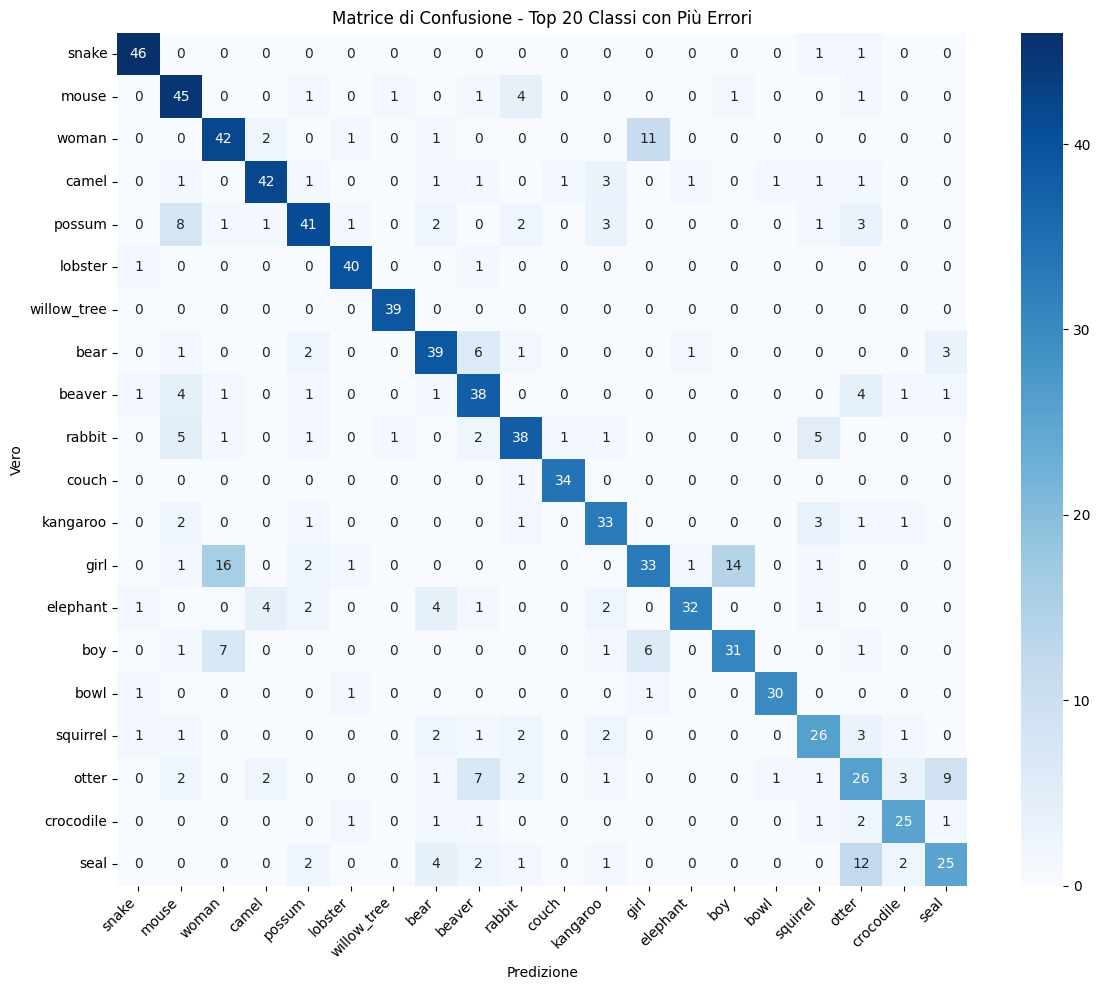

In [ ]:
# ==================================================
# MATRICE DI CONFUSIONE
# ==================================================

"""
Visualizzazione della matrice di confusione per analizzare
gli errori di classificazione più comuni
"""
def plot_confusion_matrix(y_true, y_pred, class_names, title="Matrice di Confusione"):
    """Visualizza la matrice di confusione"""
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(15, 12))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predizione')
    plt.ylabel('Vero')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Visualizzazione matrice di confusione (versione ridotta per leggibilità)
def plot_confusion_matrix_top_classes(y_true, y_pred, class_names, top_n=20):
    """Visualizza matrice di confusione per le top N classi più frequenti"""
    cm = confusion_matrix(y_true, y_pred)

    # Trova le classi con più errori
    class_errors = np.sum(cm, axis=1) - np.diag(cm)
    top_error_classes = np.argsort(class_errors)[-top_n:]

    # Sottomatrice per le classi con più errori
    cm_subset = cm[np.ix_(top_error_classes, top_error_classes)]
    class_names_subset = [class_names[i] for i in top_error_classes]

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_subset, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names_subset, yticklabels=class_names_subset)
    plt.title(f'Matrice di Confusione - Top {top_n} Classi con Più Errori')
    plt.xlabel('Predizione')
    plt.ylabel('Vero')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

plot_confusion_matrix_top_classes(y_test.flatten(), y_pred_classes, class_names)


Tramite la matrice di confusione possiamo avere una visione dettagliata degli errori di classificazione per le classi più problematiche. Ogni riga rappresenta la classe vera, mentre ogni colonna rappresenta la classe predetta. I valori sulla diagonale principale sono le predizioni corrette, mentre i valori fuori diagonale indicano gli errori di classificazione. I colori più scuri indicano un numero maggiore di campioni.

Nonostante il modello abbia una buona ccuracy complessiva, la matrice evidenzia che la performance non è uniforme su tutte le classi. Ci sono classi dove il modello si comporta molto bene, con una predizione precisa (i colori scuri sulla diagonale), ed altre invece dove fa fatica a predirre la giusta classe (colori chiari sulla diagonale o valori elevati fuori diagonale). I numeri elevati fuori dalla diagonale indicano errori frequenti.

Ad esempio, si può notare come "snake" viene predetto correttamente la maggior parte delle volte, ma ogni tanto viene confuso con "otter" o "crocodile", "woman" viene spesso confuso con "girl", ecc.
Alcuni esempi di classi dove il modello fatica maggiormente, ovvero dove la matrice di confusione registra un numero alto al di fuori della diagonale, sono "seal" confuso con "otter", "possum" confuso con "mouse", "otter" fortemente confuso con "beaver" e "seal", e così via.

La matrice di confusione si rivela uno strumento prezioso perchè, ponendo il focus sulle celle al di fuori della diagonale, è possibile individuare esattamente quali classi causano più problemi al modello e con quali altre classi vengono confuse.

In conclusione, pur avendo una accuracy complessiva buona, la matrice rende evidente che ci sono ancora margini di miglioramento significativi concentrandosi sulle classi che il modello fatica maggiormente a distinguere.

Proviamo ad analizzare nel dettagio gli errori di classificazione:

In [ ]:
# ==================================================
# ANALISI DEGLI ERRORI
# ==================================================
"""
Analisi dettagliata degli errori di classificazione
"""
def analyze_errors(y_true, y_pred, class_names, top_n=10):
    """Analizza gli errori più comuni"""
    cm = confusion_matrix(y_true, y_pred)

    # Trova gli errori più comuni (escludendo la diagonal)
    errors = []
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j and cm[i, j] > 0:
                errors.append((class_names[i], class_names[j], cm[i, j]))

    # Ordina per numero di errori
    errors.sort(key=lambda x: x[2], reverse=True)

    print(f"\nTop {top_n} errori di classificazione più comuni:")
    print("-" * 70)
    for i, (true_class, pred_class, count) in enumerate(errors[:top_n]):
        print(f"{i+1:2d}. {true_class:15s} → {pred_class:15s} ({count:3d} errori)")

analyze_errors(y_test.flatten(), y_pred_classes, class_names)


Top 10 errori di classificazione più comuni:
----------------------------------------------------------------------
 1. oak_tree        → maple_tree      ( 28 errori)
 2. crocodile       → lizard          ( 27 errori)
 3. plate           → clock           ( 26 errori)
 4. willow_tree     → maple_tree      ( 26 errori)
 5. woman           → man             ( 25 errori)
 6. boy             → man             ( 23 errori)
 7. bus             → streetcar       ( 22 errori)
 8. elephant        → cattle          ( 19 errori)
 9. boy             → baby            ( 18 errori)
10. pickup_truck    → bus             ( 18 errori)


L'elenco conferma che il modello ha difficoltà a distinguere tra classi con similitudini visive o semantiche. Tra i tipi di confusione che portano il modello a commettere gli errori più frequenti vi sono:

- oak_tree → maple_tree (28 errori): molto comune e comprensibile, dal momento che entrambe sono categorie di alberi e possono presentare caratteristiche simili, specialmente in immagini a bassa risoluzione. Il modello confonde spesso questi due tipi di alberi;
- crocodile → lizard (27 errori): coccodrilli e lucertole sono entrambi rettili con forme, colori e cute simili. Le differenze possono quindi essere sottili in un contesto di classificazione di immagini;
- plate → clock (26 errori): è un errore "strano", che potrebbe forse essere spiegato dal fatto che il modello probabilmente confonde la forma circolare o la presenza dettagli di un piatto con quelle di un orologio;
- woman → man (25 errori): è in realtà un errore comune, dovuto a differenze nell'abbigliamento, nell'acconciatura dei capelli oppure nell'angolazione dell'immagine che complica la distinzione;
- ecc.

Questa lista di errori fornisce degli spunti per affinare ulteriormente il modello, ponendo il focus sui tipi di oggetti che creano maggiore ambiguità, come ad esempio l'adozione di tecniche di data augmentation mirata per classi tipo gli alberi o i rettili che sono facilmente confondibili, in modo da enfatizzare le sottili differenze visive tra le due categorie.

Di seguito la visualizzazione di alcune predizioni corrette e sbagliate.

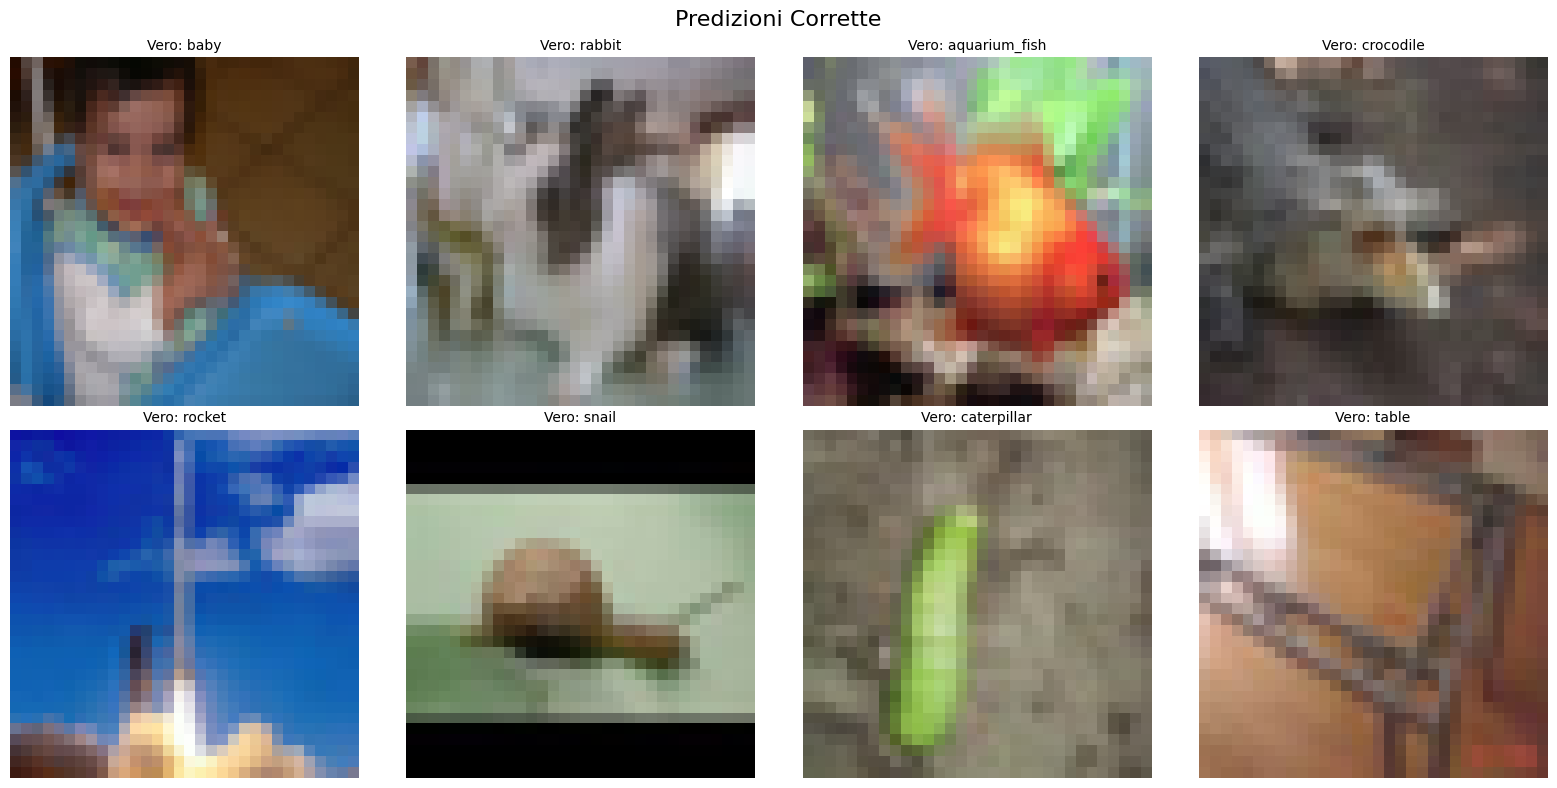

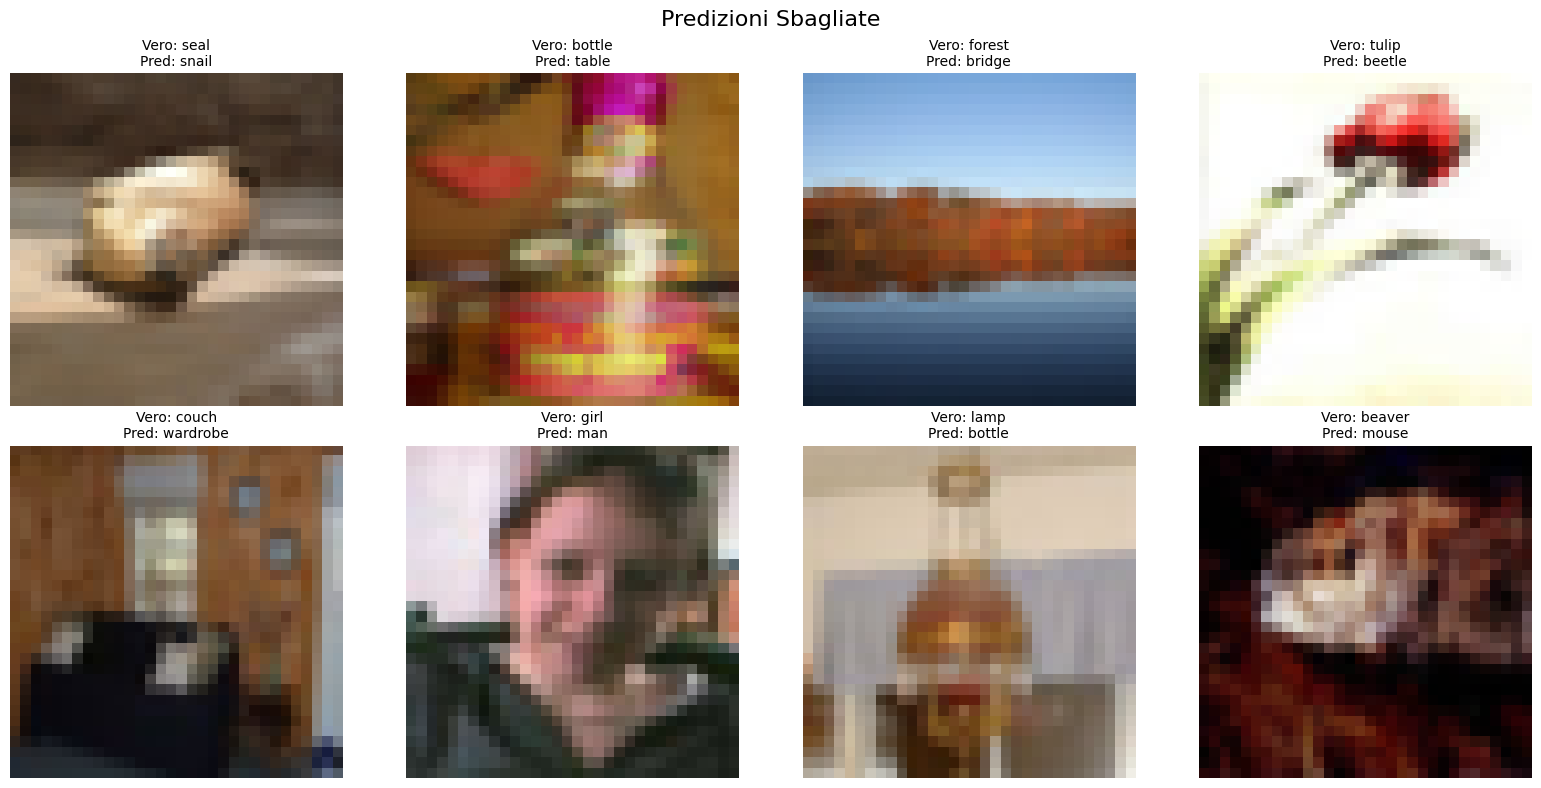

In [ ]:
# ==================================================
# VISUALIZZAZIONE PREDIZIONI CORRETTE E SBAGLIATE
# ==================================================
"""
Visualizzazione di esempi di predizioni corrette e sbagliate
"""
def visualize_predictions(x_test, y_test, y_pred, class_names, correct=True, num_samples=8):
    """Visualizza predizioni corrette o sbagliate"""
    y_test_flat = y_test.flatten()

    if correct:
        mask = y_test_flat == y_pred
        title = "Predizioni Corrette"
    else:
        mask = y_test_flat != y_pred
        title = "Predizioni Sbagliate"

    correct_indices = np.where(mask)[0]
    if len(correct_indices) == 0:
        print(f"Nessuna predizione {'corretta' if correct else 'sbagliata'} trovata!")
        return

    # Seleziona campioni casuali
    sample_indices = np.random.choice(correct_indices, min(num_samples, len(correct_indices)), replace=False)

    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle(title, fontsize=16)

    for i, ax in enumerate(axes.flat):
        if i < len(sample_indices):
            idx = sample_indices[i]
            ax.imshow(x_test[idx])

            true_label = class_names[y_test_flat[idx]]
            pred_label = class_names[y_pred[idx]]

            if correct:
                ax.set_title(f'Vero: {true_label}', fontsize=10)
            else:
                ax.set_title(f'Vero: {true_label}\nPred: {pred_label}', fontsize=10)

            ax.axis('off')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Visualizza predizioni corrette e sbagliate
visualize_predictions(x_test, y_test, y_pred_classes, class_names, correct=True)
visualize_predictions(x_test, y_test, y_pred_classes, class_names, correct=False)


Valutiamo a questo punto l'affidabilità delle predizioni del modello:


Analisi della Confidence delle Predizioni:
--------------------------------------------------
Confidence media: 0.6721
Confidence mediana: 0.6963
Confidence min: 0.0820
Confidence max: 1.0000

Confidence predizioni corrette: 0.7920
Confidence predizioni sbagliate: 0.4844


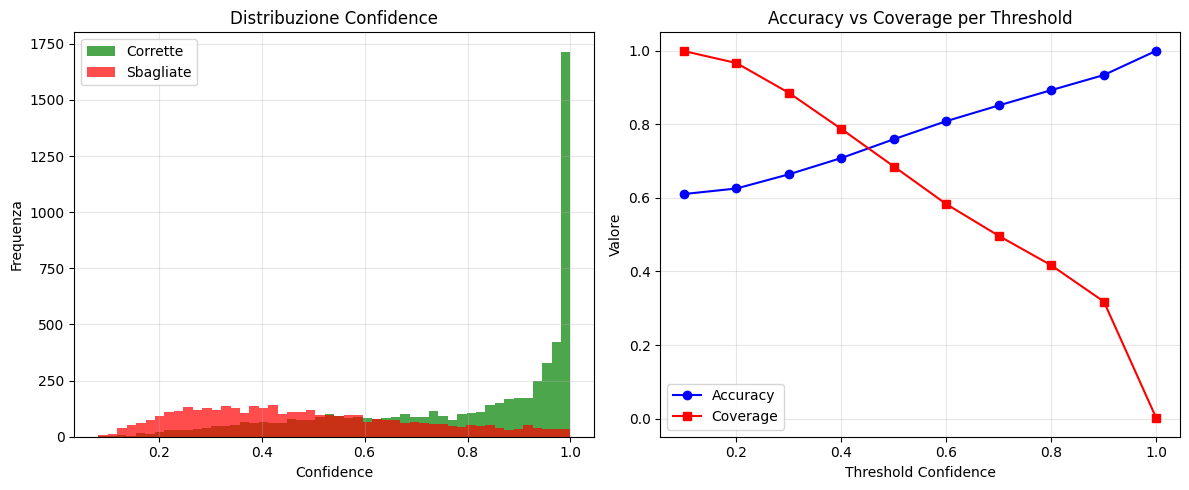

In [ ]:
# ==================================================
# ANALISI DELLE PROBABILITÀ DI PREDIZIONE
# ==================================================
"""
Analisi della confidence delle predizioni
"""
def analyze_prediction_confidence(y_pred_proba, y_true, y_pred, class_names):
    """Analizza la confidence delle predizioni"""
    max_probs = np.max(y_pred_proba, axis=1)

    # Statistiche generali
    print("\nAnalisi della Confidence delle Predizioni:")
    print("-" * 50)
    print(f"Confidence media: {np.mean(max_probs):.4f}")
    print(f"Confidence mediana: {np.median(max_probs):.4f}")
    print(f"Confidence min: {np.min(max_probs):.4f}")
    print(f"Confidence max: {np.max(max_probs):.4f}")

    # Confidence per predizioni corrette vs sbagliate
    correct_mask = y_true.flatten() == y_pred
    correct_confidence = max_probs[correct_mask]
    wrong_confidence = max_probs[~correct_mask]

    print(f"\nConfidence predizioni corrette: {np.mean(correct_confidence):.4f}")
    print(f"Confidence predizioni sbagliate: {np.mean(wrong_confidence):.4f}")

    # Grafico distribuzione confidence
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(correct_confidence, bins=50, alpha=0.7, label='Corrette', color='green')
    plt.hist(wrong_confidence, bins=50, alpha=0.7, label='Sbagliate', color='red')
    plt.xlabel('Confidence')
    plt.ylabel('Frequenza')
    plt.title('Distribuzione Confidence')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    # Confidence vs accuracy per diversi threshold
    thresholds = np.linspace(0.1, 1.0, 10)
    accuracies = []
    coverages = []

    for threshold in thresholds:
        high_conf_mask = max_probs >= threshold
        if np.sum(high_conf_mask) > 0:
            high_conf_accuracy = np.mean(correct_mask[high_conf_mask])
            coverage = np.mean(high_conf_mask)
        else:
            high_conf_accuracy = 0
            coverage = 0

        accuracies.append(high_conf_accuracy)
        coverages.append(coverage)

    plt.plot(thresholds, accuracies, 'b-', label='Accuracy', marker='o')
    plt.plot(thresholds, coverages, 'r-', label='Coverage', marker='s')
    plt.xlabel('Threshold Confidence')
    plt.ylabel('Valore')
    plt.title('Accuracy vs Coverage per Threshold')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

analyze_prediction_confidence(y_pred, y_test, y_pred_classes, class_names)

I dati sulla "confidence" delle predizioni danno un'idea dell'affidabilità e degli errori commessi dal modello (model5). I valori ottenuti suggeriscono che, in media, il modello è abbastanza sicuro delle sue previsioni, con livelli di confidence intorno a 0.70. La confidence massima raggiunge il valore pari ad 1.00, il che è positivo perchè significa che in questi casi il modello può essere molto sicuro; analogamente, la confidence minima pari a 0.0820 suggerisce che a volte il modello è molto incerto, tipicamente in presenza di classi ambigue o difficili.
I valori di
- confidence predizioni corrette: 0.7920
- confidence predizioni sbagliate: 0.4844
sono significativi: quando il modello indovina, lo fa con un'elevata sicurezza e quindi le sue previsioni corrette sono affidabili; quando il modello commette un errore, tende a farlo con una confidence significativamente più bassa. C'è quindi una chiara distinzione tra la confidence delle predizioni corrette e quelle sbagliate.

In definitiva, l'analisi della confidence è molto positiva ed anche indice del fatto che il modello non solo è accurato, ma è anche ben calibrato. Ci si potrebbe focalizzare sulle immagini per cui il modello ha una bassa confidence, soprattutto se ha sbagliato nella classificazione, per individuare ad esempio nuove aree per migliorare il dataset o l'architettura del modello, magari aggiungendo più dati per le classi confuse o implementando ulteriori tecniche di regolarizzazione.

Possiamo anche valutare le performance del modello per ogni classe, tramite un'analisi più dettagliata sulla Precision vs Recall per classe e la distribuzione dell'F1 Score, identificando anche le classi migliori e peggiori.


Top 10 classi con migliori performance (F1 score):
------------------------------------------------------------
    classe  precision  recall    f1
      road      0.916   0.870 0.892
 palm_tree      0.963   0.790 0.868
     apple      0.860   0.860 0.860
 sunflower      0.811   0.900 0.853
lawn_mower      0.962   0.750 0.843
    orange      0.748   0.890 0.813
motorcycle      0.757   0.870 0.809
     chair      0.776   0.830 0.802
skyscraper      0.821   0.780 0.800
  wardrobe      0.711   0.910 0.798

Bottom 10 classi con peggiori performance (F1 score):
------------------------------------------------------------
   classe  precision  recall    f1
 kangaroo      0.600   0.330 0.426
     bowl      0.698   0.300 0.420
    shrew      0.368   0.460 0.409
     girl      0.458   0.330 0.384
      boy      0.477   0.310 0.376
     seal      0.521   0.250 0.338
 squirrel      0.456   0.260 0.331
crocodile      0.472   0.250 0.327
   lizard      0.241   0.470 0.319
    otter      0.356   0.

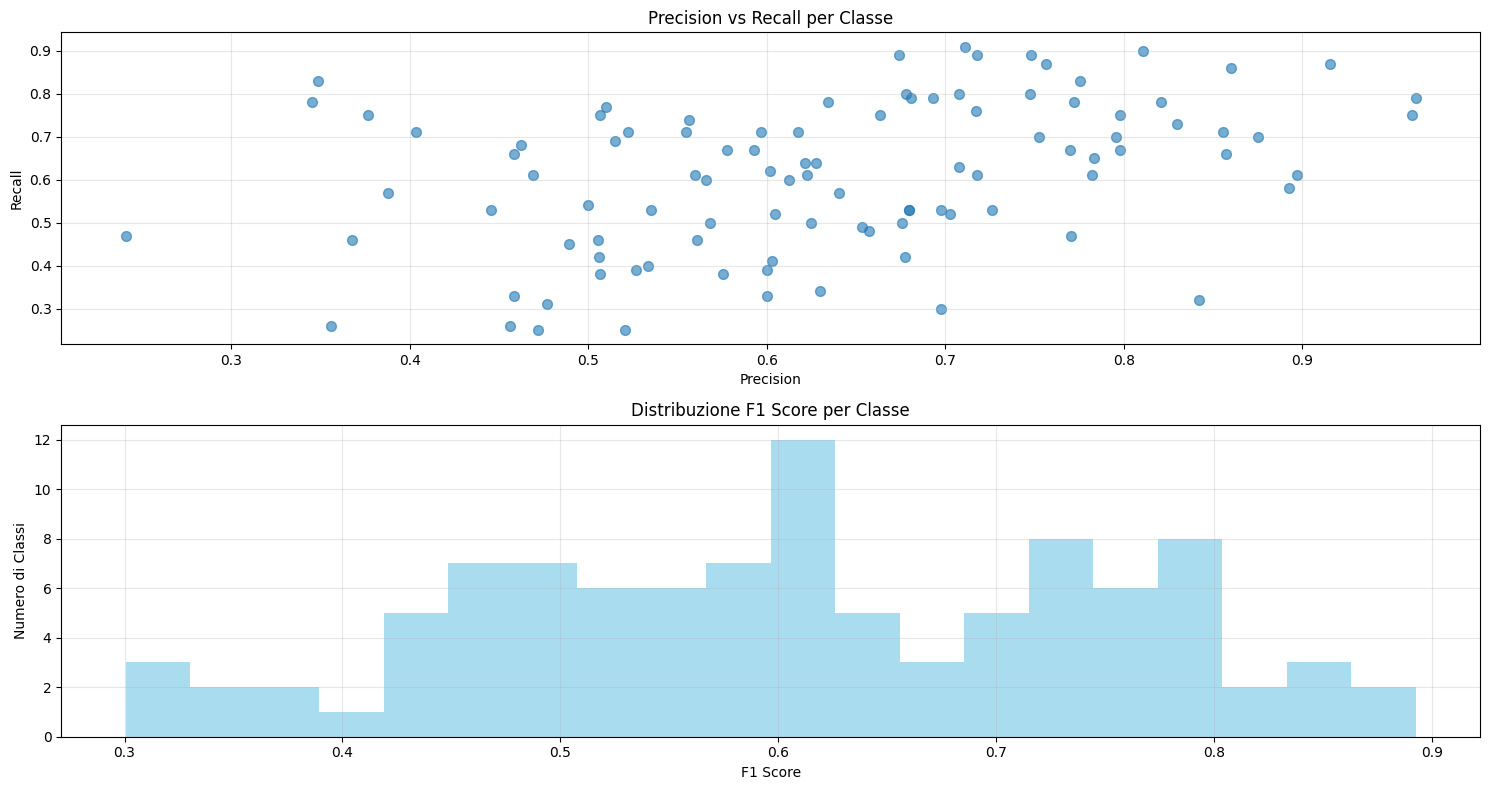

In [ ]:
# ==================================================
# ANALISI PER CLASSE
# ==================================================
"""
Analisi delle performance per ogni classe
"""
def analyze_per_class_performance(y_true, y_pred, class_names):

    y_true_flat = y_true.flatten()

    # Calcola metriche per classe
    class_metrics = []
    for i, class_name in enumerate(class_names):
        # True positives, false positives, false negatives
        tp = np.sum((y_true_flat == i) & (y_pred == i))
        fp = np.sum((y_true_flat != i) & (y_pred == i))
        fn = np.sum((y_true_flat == i) & (y_pred != i))

        # Precision, Recall, F1
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        class_metrics.append({
            'classe': class_name,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'supporto': tp + fn
        })


    df_metrics = pd.DataFrame(class_metrics)
    df_metrics = df_metrics.sort_values('f1', ascending=False) # ordino per F1score

    # Mostra top 10 e bottom 10 classi
    print("\nTop 10 classi con migliori performance (F1 score):")
    print("-" * 60)
    print(df_metrics.head(10)[['classe', 'precision', 'recall', 'f1']].to_string(index=False, float_format='%.3f'))

    print("\nBottom 10 classi con peggiori performance (F1 score):")
    print("-" * 60)
    print(df_metrics.tail(10)[['classe', 'precision', 'recall', 'f1']].to_string(index=False, float_format='%.3f'))

    # Grafico delle performance per classe
    plt.figure(figsize=(15, 8))

    plt.subplot(2, 1, 1)
    plt.scatter(df_metrics['precision'], df_metrics['recall'], alpha=0.6, s=50)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.title('Precision vs Recall per Classe')
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 1, 2)
    plt.hist(df_metrics['f1'], bins=20, alpha=0.7, color='skyblue')
    plt.xlabel('F1 Score')
    plt.ylabel('Numero di Classi')
    plt.title('Distribuzione F1 Score per Classe')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return df_metrics

df_class_metrics = analyze_per_class_performance(y_test, y_pred_classes, class_names)


Lo scatter plot mostra la relazione tra Precision (precisione delle predizioni) e Recall (copertura dei veri positivi) per ciascuna classe. si può notare come la maggior parte dei punti si concentra nella parte superiore destra del grafico, indicando che per molte classi il modello ottiene sia una buona precisione che un buon recall.

Vi sono alcuni punti che si trovano nella parte inferiore sinistra (a bassa precisione e basso recall), suggerendo quindi classi dove il modello fatica significativamente.

Guardando la distribuzione dell'F1 Score tra le diverse classi, si osserva una conferma del fatto che il modello ha buone prestazioni per un numero considerevole di classi. La maggior parte delle classi ha infatti un F1 Score compreso tra 0.55 e 0.65 e tra 0.70 e 0.80.

Il modello ResNet-34 con regolarizzazione è il più performante tra tutti, con una buona accuracy. Tuttavia, l'analisi per classe rivela che le sue capacità sono eterogenee. Si comporta molto bene nella classificazione di oggetti ben distinti (es. veicoli, frutta, città, ecc.), ma incontra difficoltà con alcune categorie, in particolare animali simili, dove la precisione e/o il recall sono infatti notevolmente inferiori. Questo è perfettamente in linea con la matrice di confusione presentata in precedenza.
Queste risultati forniscono indicazioni chiare su dove concentrare futuri sforzi di miglioramento, ad esempio con dataset più ampi o mirati per queste classi problematiche, o con tecniche di apprendimento specifiche per affinare la discriminazione.

# Conclusioni

Il presente lavoro ha affrontato lo sviluppo di un modello di classificazione di immagini partendo da un’architettura di rete neurale semplice e via via migliorata fino all’adozione di una ResNet-34, una rete residua profonda e consolidata per task di visione artificiale, con l'obiettivo di massimizzare l'accuratezza e la capacità di generalizzazione su un dataset complesso come CIFAR-100.

Inizialmente si è sperimentata una rete CNN base, caratterizzata da una struttura relativamente semplice, con risultati preliminari che hanno evidenziato margini di miglioramento significativi in termini di accuratezza e capacità di generalizzazione. Successivamente sono state introdotte varie migliorie, tra cui l’inserimento di tecniche di regolarizzazione (weight decay L2 e dropout) e strategie di data augmentation, finalizzate a limitare l’overfitting e aumentare la robustezza del modello. L'evoluzione del modello ha infatti seguito un approccio incrementale, con l'introduzione progressiva di tuning e tecniche sempre più sofisticate.

L’adozione della rete residua ResNet-34 ha rappresentato un passaggio cruciale, grazie alla capacità dei blocchi residui di facilitare l’apprendimento di reti profonde evitando problemi di vanishing gradient. Questo modello è stato scelto come modello migliore per le predizioni finali, grazie alla sua performance superiore ed alla sua robustezza rispetto ai modelli precedentemente formulati.
Riguardo le previsioni, il modello si è rivelato particolarmente performante nella classificazione di oggetti ben distinte, incontrando invece maggiori difficoltà con classi che presentano somiglianze visive o meno caratteristiche distintive, con una tendenza a confondere animali simili o specie all'interno della stessa famiglia (es. "crocodile" e "lizard", "oak_tree" e "maple_tree").

Il percorso di sviluppo intrapreso ha dimostrato che la complessità architetturale combinata con strategie di regolarizzazione e ottimizzazione avanzate è fondamentale per affrontare task di classificazione su dataset complessi come CIFAR-100. Ogni iterazione ha portato a un apprendimento più stabile e ad una migliore capacità di generalizzazione, culminando nella ResNet-34. Il modello finale, pur non raggiungendo un'accuratezza perfetta, si è dimostrato robusto e ben calibrato, fornendo previsioni affidabili per la maggior parte delle classi e identificando le aree critiche di miglioramento.
Il modello finale ha infatti raggiunto un’accuratezza superiore al 60% sul set di test, un risultato in linea con le aspettative per un dataset complesso come CIFAR-100. Questo dimostra la validità delle scelte architetturali e delle tecniche di ottimizzazione adottate.

## Sviluppi futuri

Questo studio fornisce una solida base per future ricerche, che potrebbero esplorare:
- architetture ancora più avanzate e profonde, come ResNeXt, DenseNet o EfficientNet, per migliorare l’estrazione delle caratteristiche;
- tecniche di data augmentation più sofisticate, quali CutMix e DropBlock;
- automazione dell'ottimizzazione degli iperparametri tramite tecniche di ricerca bayesiana o AutoML);
- l'utilizzo del transfer learning con modelli pre-addestrati su dataset di maggiore scala.

Un'analisi più approfondita delle classi problematiche, infine, è fondamentale per affinare ulteriormente il modello e migliorare la classificazione mirata.

In conclusione, il percorso seguito ha permesso di costruire un modello robusto e performante, offrendo una solida base per ulteriori ricerche e sviluppi nel campo della visione artificiale e del deep learning.